In [26]:
import numpy as np
import pandas as pd
import pickle
import string
from sklearn.utils import shuffle
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros([layer_dims[l], 1])
    
    return parameters

In [3]:
def relu(z):
    return np.maximum(z,0)
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [4]:
def forward_prop(X,parameters):
    
    num_layers = len(parameters)//2          #gives quotient
    linear_caches = []                       # contains A_prev,W,b
    activation_caches = []                   # contains Z
    A = X
    for l in range(1,num_layers):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]          #For relu layers
        Z = W.dot(A_prev) + b
        A = relu(Z)
        cache = [W,b,A_prev]
        linear_caches.append(cache)
        activation_caches.append(Z)
    A_prev = A
    W = parameters['W' + str(num_layers)]
    b = parameters['b' + str(num_layers)]      #For sigmoid layer at the end
    Z = W.dot(A_prev) + b
    A = sigmoid(Z)
    cache = [W,b,A_prev]
    linear_caches.append(cache)
    activation_caches.append(Z)
    caches = (linear_caches, activation_caches)
    return A, caches

In [5]:
def Loss(y_pred,Y):
    m = Y.shape[1]
    return np.sum(-Y*np.log(y_pred) - (1 - Y)*np.log(1 - y_pred))/m

In [6]:
def Loss_L2_regularization(y_pred, Y, parameters, lamda):
    num_layers = len(parameters)//2
    m = Y.shape[1]
    L2 = 0
    for l in range(1,num_layers + 1):
        L2 += np.sum(parameters['W' + str(l)]**2)
    return Loss(y_pred,Y) + lamda*L2/m

In [7]:
def activation_derivative(z, activation):
    if(activation == 'relu'):
        return 1*(z>0)
    if(activation == 'sigmoid'):
        return z*(1 -z)

In [8]:
def grad(dA, linear_cache, A, activation):
    m = A.shape[1]
    W,b,A_prev = linear_cache
    dZ = dA*activation_derivative(A, activation)           
    dW = dZ.dot(A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = (W.T).dot(dZ)
    
    return dW, db, dA_prev

In [9]:
def back_prop(y_pred,Y,caches):
    grads = {}
    linear_caches, activation_caches = caches
    num_layers = len(activation_caches)
    m = Y.shape[1]
    
    dA = -(np.divide(Y,y_pred) - np.divide((1 - Y), (1 - y_pred)))
    
    linear_cache = linear_caches[num_layers - 1]                     #Last layer
    dW,db,dA_prev = grad(dA, linear_cache, y_pred, 'sigmoid')
    grads['dW' + str(num_layers)] = dW
    grads['db' + str(num_layers)] = db
    
    for l in range(num_layers-2,-1,-1):                              #Other layers
        A = linear_caches[l+1][2]
        dW,db,dA_prev = grad(dA_prev, linear_caches[l], A , 'relu')
        grads['dW' + str(l+1)] = dW
        grads['db' + str(l+1)] = db
    
    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate):
    num_layers = len(parameters)//2
    for l in range(1,  num_layers + 1):
        parameters['W' + str(l)] -= learning_rate*grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate*grads['db' + str(l)]
    return parameters

In [11]:
def load_datasets():    
    pickle_in = open('X_Y.pickle','rb')
    X_Y = pickle.load(pickle_in)
    X = X_Y[0]
    Y = X_Y[1]
    order = np.random.permutation(X.shape[1])
    X = X[:, order]
    Y = Y[:, order]
    return X,Y

In [12]:
def my_train_test_split(X,Y):               
    X_train = X[:,:110000]
    Y_train = Y[:,:110000]
    #X_valid = X[:,110000:120000]
    #Y_valid = Y[:,110000:120000]
    X_test = X[:,110000:]
    Y_test = Y[:,110000:]
    return X_train, Y_train, X_test, Y_test #, X_valid, Y_valid 

In [13]:
def mini_batches(X_train, Y_train, num_batch):
    X_mini = X_train[:,num_batch*32:(num_batch + 1)*32]
    Y_mini = Y_train[:,num_batch*32:(num_batch + 1)*32]
    return X_mini, Y_mini

In [58]:
def predict(X_t, Y_t, parameters):
    m_t = X_t.shape[1]
    y_pred, _ = forward_prop(X_t, parameters)
    accuracy = np.sum(np.argmax(y_pred, axis =0) == np.argmax(Y_t,axis = 0))/m_t
    return y_pred, accuracy

In [15]:
def save_parameters(parameters):    
    pickle_out = open('parameters.pkl','wb')
    pickle.dump(parameters, pickle_out)
    pickle_out.close()

In [16]:
def load_parameters():
    pickle_in = open('parameters.pkl', 'rb')
    parameters = pickle.load(pickle_in)
    return parameters

In [17]:
X,Y = load_datasets()
X_train, Y_train, X_test, Y_test = my_train_test_split(X,Y)       

In [40]:
layer_dims = [784,400,50,26]
epochs = 10
losses = []
mini_batch_size = 32
m = X_train.shape[1]
valid_accuracy = []
train_accuracy = []

parameters = initialize_parameters(layer_dims)
#parameters = load_parameters()            # To load already saved parameters 

for epoch in range(epochs):
    for num_batch in range(m//mini_batch_size + 1):
        X_mini, Y_mini = mini_batches(X_train, Y_train, num_batch)
        y_pred, caches = forward_prop(X_mini,parameters) 
        loss = Loss(y_pred,Y_mini)
        losses.append(loss)
        grads = back_prop(y_pred,Y_mini,caches)
        parameters = update_parameters(parameters, grads, learning_rate = 0.1)
        
#         _, valid_acc = predict(X_valid, Y_valid, parameters)
#         _, train_acc = predict(X_mini, Y_mini, parameters)
        
#         valid_accuracy.append(valid_acc)
#         train_accuracy.append(train_acc)
        print('epoch' + str(epoch) + '-' + str(num_batch) + '/' + str(m//mini_batch_size))
save_parameters(parameters)

epoch0-0/3437
epoch0-1/3437
epoch0-2/3437
epoch0-3/3437
epoch0-4/3437
epoch0-5/3437
epoch0-6/3437
epoch0-7/3437
epoch0-8/3437
epoch0-9/3437
epoch0-10/3437
epoch0-11/3437
epoch0-12/3437
epoch0-13/3437
epoch0-14/3437
epoch0-15/3437
epoch0-16/3437
epoch0-17/3437
epoch0-18/3437
epoch0-19/3437
epoch0-20/3437
epoch0-21/3437
epoch0-22/3437
epoch0-23/3437
epoch0-24/3437
epoch0-25/3437
epoch0-26/3437
epoch0-27/3437
epoch0-28/3437
epoch0-29/3437
epoch0-30/3437
epoch0-31/3437
epoch0-32/3437
epoch0-33/3437
epoch0-34/3437
epoch0-35/3437
epoch0-36/3437
epoch0-37/3437
epoch0-38/3437
epoch0-39/3437
epoch0-40/3437
epoch0-41/3437
epoch0-42/3437
epoch0-43/3437
epoch0-44/3437
epoch0-45/3437
epoch0-46/3437
epoch0-47/3437
epoch0-48/3437
epoch0-49/3437
epoch0-50/3437
epoch0-51/3437
epoch0-52/3437
epoch0-53/3437
epoch0-54/3437
epoch0-55/3437
epoch0-56/3437
epoch0-57/3437
epoch0-58/3437
epoch0-59/3437
epoch0-60/3437
epoch0-61/3437
epoch0-62/3437
epoch0-63/3437
epoch0-64/3437
epoch0-65/3437
epoch0-66/3437
epoch

epoch0-547/3437
epoch0-548/3437
epoch0-549/3437
epoch0-550/3437
epoch0-551/3437
epoch0-552/3437
epoch0-553/3437
epoch0-554/3437
epoch0-555/3437
epoch0-556/3437
epoch0-557/3437
epoch0-558/3437
epoch0-559/3437
epoch0-560/3437
epoch0-561/3437
epoch0-562/3437
epoch0-563/3437
epoch0-564/3437
epoch0-565/3437
epoch0-566/3437
epoch0-567/3437
epoch0-568/3437
epoch0-569/3437
epoch0-570/3437
epoch0-571/3437
epoch0-572/3437
epoch0-573/3437
epoch0-574/3437
epoch0-575/3437
epoch0-576/3437
epoch0-577/3437
epoch0-578/3437
epoch0-579/3437
epoch0-580/3437
epoch0-581/3437
epoch0-582/3437
epoch0-583/3437
epoch0-584/3437
epoch0-585/3437
epoch0-586/3437
epoch0-587/3437
epoch0-588/3437
epoch0-589/3437
epoch0-590/3437
epoch0-591/3437
epoch0-592/3437
epoch0-593/3437
epoch0-594/3437
epoch0-595/3437
epoch0-596/3437
epoch0-597/3437
epoch0-598/3437
epoch0-599/3437
epoch0-600/3437
epoch0-601/3437
epoch0-602/3437
epoch0-603/3437
epoch0-604/3437
epoch0-605/3437
epoch0-606/3437
epoch0-607/3437
epoch0-608/3437
epoch0-6

epoch0-1069/3437
epoch0-1070/3437
epoch0-1071/3437
epoch0-1072/3437
epoch0-1073/3437
epoch0-1074/3437
epoch0-1075/3437
epoch0-1076/3437
epoch0-1077/3437
epoch0-1078/3437
epoch0-1079/3437
epoch0-1080/3437
epoch0-1081/3437
epoch0-1082/3437
epoch0-1083/3437
epoch0-1084/3437
epoch0-1085/3437
epoch0-1086/3437
epoch0-1087/3437
epoch0-1088/3437
epoch0-1089/3437
epoch0-1090/3437
epoch0-1091/3437
epoch0-1092/3437
epoch0-1093/3437
epoch0-1094/3437
epoch0-1095/3437
epoch0-1096/3437
epoch0-1097/3437
epoch0-1098/3437
epoch0-1099/3437
epoch0-1100/3437
epoch0-1101/3437
epoch0-1102/3437
epoch0-1103/3437
epoch0-1104/3437
epoch0-1105/3437
epoch0-1106/3437
epoch0-1107/3437
epoch0-1108/3437
epoch0-1109/3437
epoch0-1110/3437
epoch0-1111/3437
epoch0-1112/3437
epoch0-1113/3437
epoch0-1114/3437
epoch0-1115/3437
epoch0-1116/3437
epoch0-1117/3437
epoch0-1118/3437
epoch0-1119/3437
epoch0-1120/3437
epoch0-1121/3437
epoch0-1122/3437
epoch0-1123/3437
epoch0-1124/3437
epoch0-1125/3437
epoch0-1126/3437
epoch0-1127/34

epoch0-1571/3437
epoch0-1572/3437
epoch0-1573/3437
epoch0-1574/3437
epoch0-1575/3437
epoch0-1576/3437
epoch0-1577/3437
epoch0-1578/3437
epoch0-1579/3437
epoch0-1580/3437
epoch0-1581/3437
epoch0-1582/3437
epoch0-1583/3437
epoch0-1584/3437
epoch0-1585/3437
epoch0-1586/3437
epoch0-1587/3437
epoch0-1588/3437
epoch0-1589/3437
epoch0-1590/3437
epoch0-1591/3437
epoch0-1592/3437
epoch0-1593/3437
epoch0-1594/3437
epoch0-1595/3437
epoch0-1596/3437
epoch0-1597/3437
epoch0-1598/3437
epoch0-1599/3437
epoch0-1600/3437
epoch0-1601/3437
epoch0-1602/3437
epoch0-1603/3437
epoch0-1604/3437
epoch0-1605/3437
epoch0-1606/3437
epoch0-1607/3437
epoch0-1608/3437
epoch0-1609/3437
epoch0-1610/3437
epoch0-1611/3437
epoch0-1612/3437
epoch0-1613/3437
epoch0-1614/3437
epoch0-1615/3437
epoch0-1616/3437
epoch0-1617/3437
epoch0-1618/3437
epoch0-1619/3437
epoch0-1620/3437
epoch0-1621/3437
epoch0-1622/3437
epoch0-1623/3437
epoch0-1624/3437
epoch0-1625/3437
epoch0-1626/3437
epoch0-1627/3437
epoch0-1628/3437
epoch0-1629/34

epoch0-2067/3437
epoch0-2068/3437
epoch0-2069/3437
epoch0-2070/3437
epoch0-2071/3437
epoch0-2072/3437
epoch0-2073/3437
epoch0-2074/3437
epoch0-2075/3437
epoch0-2076/3437
epoch0-2077/3437
epoch0-2078/3437
epoch0-2079/3437
epoch0-2080/3437
epoch0-2081/3437
epoch0-2082/3437
epoch0-2083/3437
epoch0-2084/3437
epoch0-2085/3437
epoch0-2086/3437
epoch0-2087/3437
epoch0-2088/3437
epoch0-2089/3437
epoch0-2090/3437
epoch0-2091/3437
epoch0-2092/3437
epoch0-2093/3437
epoch0-2094/3437
epoch0-2095/3437
epoch0-2096/3437
epoch0-2097/3437
epoch0-2098/3437
epoch0-2099/3437
epoch0-2100/3437
epoch0-2101/3437
epoch0-2102/3437
epoch0-2103/3437
epoch0-2104/3437
epoch0-2105/3437
epoch0-2106/3437
epoch0-2107/3437
epoch0-2108/3437
epoch0-2109/3437
epoch0-2110/3437
epoch0-2111/3437
epoch0-2112/3437
epoch0-2113/3437
epoch0-2114/3437
epoch0-2115/3437
epoch0-2116/3437
epoch0-2117/3437
epoch0-2118/3437
epoch0-2119/3437
epoch0-2120/3437
epoch0-2121/3437
epoch0-2122/3437
epoch0-2123/3437
epoch0-2124/3437
epoch0-2125/34

epoch0-2569/3437
epoch0-2570/3437
epoch0-2571/3437
epoch0-2572/3437
epoch0-2573/3437
epoch0-2574/3437
epoch0-2575/3437
epoch0-2576/3437
epoch0-2577/3437
epoch0-2578/3437
epoch0-2579/3437
epoch0-2580/3437
epoch0-2581/3437
epoch0-2582/3437
epoch0-2583/3437
epoch0-2584/3437
epoch0-2585/3437
epoch0-2586/3437
epoch0-2587/3437
epoch0-2588/3437
epoch0-2589/3437
epoch0-2590/3437
epoch0-2591/3437
epoch0-2592/3437
epoch0-2593/3437
epoch0-2594/3437
epoch0-2595/3437
epoch0-2596/3437
epoch0-2597/3437
epoch0-2598/3437
epoch0-2599/3437
epoch0-2600/3437
epoch0-2601/3437
epoch0-2602/3437
epoch0-2603/3437
epoch0-2604/3437
epoch0-2605/3437
epoch0-2606/3437
epoch0-2607/3437
epoch0-2608/3437
epoch0-2609/3437
epoch0-2610/3437
epoch0-2611/3437
epoch0-2612/3437
epoch0-2613/3437
epoch0-2614/3437
epoch0-2615/3437
epoch0-2616/3437
epoch0-2617/3437
epoch0-2618/3437
epoch0-2619/3437
epoch0-2620/3437
epoch0-2621/3437
epoch0-2622/3437
epoch0-2623/3437
epoch0-2624/3437
epoch0-2625/3437
epoch0-2626/3437
epoch0-2627/34

epoch0-3067/3437
epoch0-3068/3437
epoch0-3069/3437
epoch0-3070/3437
epoch0-3071/3437
epoch0-3072/3437
epoch0-3073/3437
epoch0-3074/3437
epoch0-3075/3437
epoch0-3076/3437
epoch0-3077/3437
epoch0-3078/3437
epoch0-3079/3437
epoch0-3080/3437
epoch0-3081/3437
epoch0-3082/3437
epoch0-3083/3437
epoch0-3084/3437
epoch0-3085/3437
epoch0-3086/3437
epoch0-3087/3437
epoch0-3088/3437
epoch0-3089/3437
epoch0-3090/3437
epoch0-3091/3437
epoch0-3092/3437
epoch0-3093/3437
epoch0-3094/3437
epoch0-3095/3437
epoch0-3096/3437
epoch0-3097/3437
epoch0-3098/3437
epoch0-3099/3437
epoch0-3100/3437
epoch0-3101/3437
epoch0-3102/3437
epoch0-3103/3437
epoch0-3104/3437
epoch0-3105/3437
epoch0-3106/3437
epoch0-3107/3437
epoch0-3108/3437
epoch0-3109/3437
epoch0-3110/3437
epoch0-3111/3437
epoch0-3112/3437
epoch0-3113/3437
epoch0-3114/3437
epoch0-3115/3437
epoch0-3116/3437
epoch0-3117/3437
epoch0-3118/3437
epoch0-3119/3437
epoch0-3120/3437
epoch0-3121/3437
epoch0-3122/3437
epoch0-3123/3437
epoch0-3124/3437
epoch0-3125/34

epoch1-140/3437
epoch1-141/3437
epoch1-142/3437
epoch1-143/3437
epoch1-144/3437
epoch1-145/3437
epoch1-146/3437
epoch1-147/3437
epoch1-148/3437
epoch1-149/3437
epoch1-150/3437
epoch1-151/3437
epoch1-152/3437
epoch1-153/3437
epoch1-154/3437
epoch1-155/3437
epoch1-156/3437
epoch1-157/3437
epoch1-158/3437
epoch1-159/3437
epoch1-160/3437
epoch1-161/3437
epoch1-162/3437
epoch1-163/3437
epoch1-164/3437
epoch1-165/3437
epoch1-166/3437
epoch1-167/3437
epoch1-168/3437
epoch1-169/3437
epoch1-170/3437
epoch1-171/3437
epoch1-172/3437
epoch1-173/3437
epoch1-174/3437
epoch1-175/3437
epoch1-176/3437
epoch1-177/3437
epoch1-178/3437
epoch1-179/3437
epoch1-180/3437
epoch1-181/3437
epoch1-182/3437
epoch1-183/3437
epoch1-184/3437
epoch1-185/3437
epoch1-186/3437
epoch1-187/3437
epoch1-188/3437
epoch1-189/3437
epoch1-190/3437
epoch1-191/3437
epoch1-192/3437
epoch1-193/3437
epoch1-194/3437
epoch1-195/3437
epoch1-196/3437
epoch1-197/3437
epoch1-198/3437
epoch1-199/3437
epoch1-200/3437
epoch1-201/3437
epoch1-2

epoch1-659/3437
epoch1-660/3437
epoch1-661/3437
epoch1-662/3437
epoch1-663/3437
epoch1-664/3437
epoch1-665/3437
epoch1-666/3437
epoch1-667/3437
epoch1-668/3437
epoch1-669/3437
epoch1-670/3437
epoch1-671/3437
epoch1-672/3437
epoch1-673/3437
epoch1-674/3437
epoch1-675/3437
epoch1-676/3437
epoch1-677/3437
epoch1-678/3437
epoch1-679/3437
epoch1-680/3437
epoch1-681/3437
epoch1-682/3437
epoch1-683/3437
epoch1-684/3437
epoch1-685/3437
epoch1-686/3437
epoch1-687/3437
epoch1-688/3437
epoch1-689/3437
epoch1-690/3437
epoch1-691/3437
epoch1-692/3437
epoch1-693/3437
epoch1-694/3437
epoch1-695/3437
epoch1-696/3437
epoch1-697/3437
epoch1-698/3437
epoch1-699/3437
epoch1-700/3437
epoch1-701/3437
epoch1-702/3437
epoch1-703/3437
epoch1-704/3437
epoch1-705/3437
epoch1-706/3437
epoch1-707/3437
epoch1-708/3437
epoch1-709/3437
epoch1-710/3437
epoch1-711/3437
epoch1-712/3437
epoch1-713/3437
epoch1-714/3437
epoch1-715/3437
epoch1-716/3437
epoch1-717/3437
epoch1-718/3437
epoch1-719/3437
epoch1-720/3437
epoch1-7

epoch1-1174/3437
epoch1-1175/3437
epoch1-1176/3437
epoch1-1177/3437
epoch1-1178/3437
epoch1-1179/3437
epoch1-1180/3437
epoch1-1181/3437
epoch1-1182/3437
epoch1-1183/3437
epoch1-1184/3437
epoch1-1185/3437
epoch1-1186/3437
epoch1-1187/3437
epoch1-1188/3437
epoch1-1189/3437
epoch1-1190/3437
epoch1-1191/3437
epoch1-1192/3437
epoch1-1193/3437
epoch1-1194/3437
epoch1-1195/3437
epoch1-1196/3437
epoch1-1197/3437
epoch1-1198/3437
epoch1-1199/3437
epoch1-1200/3437
epoch1-1201/3437
epoch1-1202/3437
epoch1-1203/3437
epoch1-1204/3437
epoch1-1205/3437
epoch1-1206/3437
epoch1-1207/3437
epoch1-1208/3437
epoch1-1209/3437
epoch1-1210/3437
epoch1-1211/3437
epoch1-1212/3437
epoch1-1213/3437
epoch1-1214/3437
epoch1-1215/3437
epoch1-1216/3437
epoch1-1217/3437
epoch1-1218/3437
epoch1-1219/3437
epoch1-1220/3437
epoch1-1221/3437
epoch1-1222/3437
epoch1-1223/3437
epoch1-1224/3437
epoch1-1225/3437
epoch1-1226/3437
epoch1-1227/3437
epoch1-1228/3437
epoch1-1229/3437
epoch1-1230/3437
epoch1-1231/3437
epoch1-1232/34

epoch1-1663/3437
epoch1-1664/3437
epoch1-1665/3437
epoch1-1666/3437
epoch1-1667/3437
epoch1-1668/3437
epoch1-1669/3437
epoch1-1670/3437
epoch1-1671/3437
epoch1-1672/3437
epoch1-1673/3437
epoch1-1674/3437
epoch1-1675/3437
epoch1-1676/3437
epoch1-1677/3437
epoch1-1678/3437
epoch1-1679/3437
epoch1-1680/3437
epoch1-1681/3437
epoch1-1682/3437
epoch1-1683/3437
epoch1-1684/3437
epoch1-1685/3437
epoch1-1686/3437
epoch1-1687/3437
epoch1-1688/3437
epoch1-1689/3437
epoch1-1690/3437
epoch1-1691/3437
epoch1-1692/3437
epoch1-1693/3437
epoch1-1694/3437
epoch1-1695/3437
epoch1-1696/3437
epoch1-1697/3437
epoch1-1698/3437
epoch1-1699/3437
epoch1-1700/3437
epoch1-1701/3437
epoch1-1702/3437
epoch1-1703/3437
epoch1-1704/3437
epoch1-1705/3437
epoch1-1706/3437
epoch1-1707/3437
epoch1-1708/3437
epoch1-1709/3437
epoch1-1710/3437
epoch1-1711/3437
epoch1-1712/3437
epoch1-1713/3437
epoch1-1714/3437
epoch1-1715/3437
epoch1-1716/3437
epoch1-1717/3437
epoch1-1718/3437
epoch1-1719/3437
epoch1-1720/3437
epoch1-1721/34

epoch1-2146/3437
epoch1-2147/3437
epoch1-2148/3437
epoch1-2149/3437
epoch1-2150/3437
epoch1-2151/3437
epoch1-2152/3437
epoch1-2153/3437
epoch1-2154/3437
epoch1-2155/3437
epoch1-2156/3437
epoch1-2157/3437
epoch1-2158/3437
epoch1-2159/3437
epoch1-2160/3437
epoch1-2161/3437
epoch1-2162/3437
epoch1-2163/3437
epoch1-2164/3437
epoch1-2165/3437
epoch1-2166/3437
epoch1-2167/3437
epoch1-2168/3437
epoch1-2169/3437
epoch1-2170/3437
epoch1-2171/3437
epoch1-2172/3437
epoch1-2173/3437
epoch1-2174/3437
epoch1-2175/3437
epoch1-2176/3437
epoch1-2177/3437
epoch1-2178/3437
epoch1-2179/3437
epoch1-2180/3437
epoch1-2181/3437
epoch1-2182/3437
epoch1-2183/3437
epoch1-2184/3437
epoch1-2185/3437
epoch1-2186/3437
epoch1-2187/3437
epoch1-2188/3437
epoch1-2189/3437
epoch1-2190/3437
epoch1-2191/3437
epoch1-2192/3437
epoch1-2193/3437
epoch1-2194/3437
epoch1-2195/3437
epoch1-2196/3437
epoch1-2197/3437
epoch1-2198/3437
epoch1-2199/3437
epoch1-2200/3437
epoch1-2201/3437
epoch1-2202/3437
epoch1-2203/3437
epoch1-2204/34

epoch1-2654/3437
epoch1-2655/3437
epoch1-2656/3437
epoch1-2657/3437
epoch1-2658/3437
epoch1-2659/3437
epoch1-2660/3437
epoch1-2661/3437
epoch1-2662/3437
epoch1-2663/3437
epoch1-2664/3437
epoch1-2665/3437
epoch1-2666/3437
epoch1-2667/3437
epoch1-2668/3437
epoch1-2669/3437
epoch1-2670/3437
epoch1-2671/3437
epoch1-2672/3437
epoch1-2673/3437
epoch1-2674/3437
epoch1-2675/3437
epoch1-2676/3437
epoch1-2677/3437
epoch1-2678/3437
epoch1-2679/3437
epoch1-2680/3437
epoch1-2681/3437
epoch1-2682/3437
epoch1-2683/3437
epoch1-2684/3437
epoch1-2685/3437
epoch1-2686/3437
epoch1-2687/3437
epoch1-2688/3437
epoch1-2689/3437
epoch1-2690/3437
epoch1-2691/3437
epoch1-2692/3437
epoch1-2693/3437
epoch1-2694/3437
epoch1-2695/3437
epoch1-2696/3437
epoch1-2697/3437
epoch1-2698/3437
epoch1-2699/3437
epoch1-2700/3437
epoch1-2701/3437
epoch1-2702/3437
epoch1-2703/3437
epoch1-2704/3437
epoch1-2705/3437
epoch1-2706/3437
epoch1-2707/3437
epoch1-2708/3437
epoch1-2709/3437
epoch1-2710/3437
epoch1-2711/3437
epoch1-2712/34

epoch1-3164/3437
epoch1-3165/3437
epoch1-3166/3437
epoch1-3167/3437
epoch1-3168/3437
epoch1-3169/3437
epoch1-3170/3437
epoch1-3171/3437
epoch1-3172/3437
epoch1-3173/3437
epoch1-3174/3437
epoch1-3175/3437
epoch1-3176/3437
epoch1-3177/3437
epoch1-3178/3437
epoch1-3179/3437
epoch1-3180/3437
epoch1-3181/3437
epoch1-3182/3437
epoch1-3183/3437
epoch1-3184/3437
epoch1-3185/3437
epoch1-3186/3437
epoch1-3187/3437
epoch1-3188/3437
epoch1-3189/3437
epoch1-3190/3437
epoch1-3191/3437
epoch1-3192/3437
epoch1-3193/3437
epoch1-3194/3437
epoch1-3195/3437
epoch1-3196/3437
epoch1-3197/3437
epoch1-3198/3437
epoch1-3199/3437
epoch1-3200/3437
epoch1-3201/3437
epoch1-3202/3437
epoch1-3203/3437
epoch1-3204/3437
epoch1-3205/3437
epoch1-3206/3437
epoch1-3207/3437
epoch1-3208/3437
epoch1-3209/3437
epoch1-3210/3437
epoch1-3211/3437
epoch1-3212/3437
epoch1-3213/3437
epoch1-3214/3437
epoch1-3215/3437
epoch1-3216/3437
epoch1-3217/3437
epoch1-3218/3437
epoch1-3219/3437
epoch1-3220/3437
epoch1-3221/3437
epoch1-3222/34

epoch2-244/3437
epoch2-245/3437
epoch2-246/3437
epoch2-247/3437
epoch2-248/3437
epoch2-249/3437
epoch2-250/3437
epoch2-251/3437
epoch2-252/3437
epoch2-253/3437
epoch2-254/3437
epoch2-255/3437
epoch2-256/3437
epoch2-257/3437
epoch2-258/3437
epoch2-259/3437
epoch2-260/3437
epoch2-261/3437
epoch2-262/3437
epoch2-263/3437
epoch2-264/3437
epoch2-265/3437
epoch2-266/3437
epoch2-267/3437
epoch2-268/3437
epoch2-269/3437
epoch2-270/3437
epoch2-271/3437
epoch2-272/3437
epoch2-273/3437
epoch2-274/3437
epoch2-275/3437
epoch2-276/3437
epoch2-277/3437
epoch2-278/3437
epoch2-279/3437
epoch2-280/3437
epoch2-281/3437
epoch2-282/3437
epoch2-283/3437
epoch2-284/3437
epoch2-285/3437
epoch2-286/3437
epoch2-287/3437
epoch2-288/3437
epoch2-289/3437
epoch2-290/3437
epoch2-291/3437
epoch2-292/3437
epoch2-293/3437
epoch2-294/3437
epoch2-295/3437
epoch2-296/3437
epoch2-297/3437
epoch2-298/3437
epoch2-299/3437
epoch2-300/3437
epoch2-301/3437
epoch2-302/3437
epoch2-303/3437
epoch2-304/3437
epoch2-305/3437
epoch2-3

epoch2-776/3437
epoch2-777/3437
epoch2-778/3437
epoch2-779/3437
epoch2-780/3437
epoch2-781/3437
epoch2-782/3437
epoch2-783/3437
epoch2-784/3437
epoch2-785/3437
epoch2-786/3437
epoch2-787/3437
epoch2-788/3437
epoch2-789/3437
epoch2-790/3437
epoch2-791/3437
epoch2-792/3437
epoch2-793/3437
epoch2-794/3437
epoch2-795/3437
epoch2-796/3437
epoch2-797/3437
epoch2-798/3437
epoch2-799/3437
epoch2-800/3437
epoch2-801/3437
epoch2-802/3437
epoch2-803/3437
epoch2-804/3437
epoch2-805/3437
epoch2-806/3437
epoch2-807/3437
epoch2-808/3437
epoch2-809/3437
epoch2-810/3437
epoch2-811/3437
epoch2-812/3437
epoch2-813/3437
epoch2-814/3437
epoch2-815/3437
epoch2-816/3437
epoch2-817/3437
epoch2-818/3437
epoch2-819/3437
epoch2-820/3437
epoch2-821/3437
epoch2-822/3437
epoch2-823/3437
epoch2-824/3437
epoch2-825/3437
epoch2-826/3437
epoch2-827/3437
epoch2-828/3437
epoch2-829/3437
epoch2-830/3437
epoch2-831/3437
epoch2-832/3437
epoch2-833/3437
epoch2-834/3437
epoch2-835/3437
epoch2-836/3437
epoch2-837/3437
epoch2-8

epoch2-1292/3437
epoch2-1293/3437
epoch2-1294/3437
epoch2-1295/3437
epoch2-1296/3437
epoch2-1297/3437
epoch2-1298/3437
epoch2-1299/3437
epoch2-1300/3437
epoch2-1301/3437
epoch2-1302/3437
epoch2-1303/3437
epoch2-1304/3437
epoch2-1305/3437
epoch2-1306/3437
epoch2-1307/3437
epoch2-1308/3437
epoch2-1309/3437
epoch2-1310/3437
epoch2-1311/3437
epoch2-1312/3437
epoch2-1313/3437
epoch2-1314/3437
epoch2-1315/3437
epoch2-1316/3437
epoch2-1317/3437
epoch2-1318/3437
epoch2-1319/3437
epoch2-1320/3437
epoch2-1321/3437
epoch2-1322/3437
epoch2-1323/3437
epoch2-1324/3437
epoch2-1325/3437
epoch2-1326/3437
epoch2-1327/3437
epoch2-1328/3437
epoch2-1329/3437
epoch2-1330/3437
epoch2-1331/3437
epoch2-1332/3437
epoch2-1333/3437
epoch2-1334/3437
epoch2-1335/3437
epoch2-1336/3437
epoch2-1337/3437
epoch2-1338/3437
epoch2-1339/3437
epoch2-1340/3437
epoch2-1341/3437
epoch2-1342/3437
epoch2-1343/3437
epoch2-1344/3437
epoch2-1345/3437
epoch2-1346/3437
epoch2-1347/3437
epoch2-1348/3437
epoch2-1349/3437
epoch2-1350/34

epoch2-1789/3437
epoch2-1790/3437
epoch2-1791/3437
epoch2-1792/3437
epoch2-1793/3437
epoch2-1794/3437
epoch2-1795/3437
epoch2-1796/3437
epoch2-1797/3437
epoch2-1798/3437
epoch2-1799/3437
epoch2-1800/3437
epoch2-1801/3437
epoch2-1802/3437
epoch2-1803/3437
epoch2-1804/3437
epoch2-1805/3437
epoch2-1806/3437
epoch2-1807/3437
epoch2-1808/3437
epoch2-1809/3437
epoch2-1810/3437
epoch2-1811/3437
epoch2-1812/3437
epoch2-1813/3437
epoch2-1814/3437
epoch2-1815/3437
epoch2-1816/3437
epoch2-1817/3437
epoch2-1818/3437
epoch2-1819/3437
epoch2-1820/3437
epoch2-1821/3437
epoch2-1822/3437
epoch2-1823/3437
epoch2-1824/3437
epoch2-1825/3437
epoch2-1826/3437
epoch2-1827/3437
epoch2-1828/3437
epoch2-1829/3437
epoch2-1830/3437
epoch2-1831/3437
epoch2-1832/3437
epoch2-1833/3437
epoch2-1834/3437
epoch2-1835/3437
epoch2-1836/3437
epoch2-1837/3437
epoch2-1838/3437
epoch2-1839/3437
epoch2-1840/3437
epoch2-1841/3437
epoch2-1842/3437
epoch2-1843/3437
epoch2-1844/3437
epoch2-1845/3437
epoch2-1846/3437
epoch2-1847/34

epoch2-2283/3437
epoch2-2284/3437
epoch2-2285/3437
epoch2-2286/3437
epoch2-2287/3437
epoch2-2288/3437
epoch2-2289/3437
epoch2-2290/3437
epoch2-2291/3437
epoch2-2292/3437
epoch2-2293/3437
epoch2-2294/3437
epoch2-2295/3437
epoch2-2296/3437
epoch2-2297/3437
epoch2-2298/3437
epoch2-2299/3437
epoch2-2300/3437
epoch2-2301/3437
epoch2-2302/3437
epoch2-2303/3437
epoch2-2304/3437
epoch2-2305/3437
epoch2-2306/3437
epoch2-2307/3437
epoch2-2308/3437
epoch2-2309/3437
epoch2-2310/3437
epoch2-2311/3437
epoch2-2312/3437
epoch2-2313/3437
epoch2-2314/3437
epoch2-2315/3437
epoch2-2316/3437
epoch2-2317/3437
epoch2-2318/3437
epoch2-2319/3437
epoch2-2320/3437
epoch2-2321/3437
epoch2-2322/3437
epoch2-2323/3437
epoch2-2324/3437
epoch2-2325/3437
epoch2-2326/3437
epoch2-2327/3437
epoch2-2328/3437
epoch2-2329/3437
epoch2-2330/3437
epoch2-2331/3437
epoch2-2332/3437
epoch2-2333/3437
epoch2-2334/3437
epoch2-2335/3437
epoch2-2336/3437
epoch2-2337/3437
epoch2-2338/3437
epoch2-2339/3437
epoch2-2340/3437
epoch2-2341/34

epoch2-2786/3437
epoch2-2787/3437
epoch2-2788/3437
epoch2-2789/3437
epoch2-2790/3437
epoch2-2791/3437
epoch2-2792/3437
epoch2-2793/3437
epoch2-2794/3437
epoch2-2795/3437
epoch2-2796/3437
epoch2-2797/3437
epoch2-2798/3437
epoch2-2799/3437
epoch2-2800/3437
epoch2-2801/3437
epoch2-2802/3437
epoch2-2803/3437
epoch2-2804/3437
epoch2-2805/3437
epoch2-2806/3437
epoch2-2807/3437
epoch2-2808/3437
epoch2-2809/3437
epoch2-2810/3437
epoch2-2811/3437
epoch2-2812/3437
epoch2-2813/3437
epoch2-2814/3437
epoch2-2815/3437
epoch2-2816/3437
epoch2-2817/3437
epoch2-2818/3437
epoch2-2819/3437
epoch2-2820/3437
epoch2-2821/3437
epoch2-2822/3437
epoch2-2823/3437
epoch2-2824/3437
epoch2-2825/3437
epoch2-2826/3437
epoch2-2827/3437
epoch2-2828/3437
epoch2-2829/3437
epoch2-2830/3437
epoch2-2831/3437
epoch2-2832/3437
epoch2-2833/3437
epoch2-2834/3437
epoch2-2835/3437
epoch2-2836/3437
epoch2-2837/3437
epoch2-2838/3437
epoch2-2839/3437
epoch2-2840/3437
epoch2-2841/3437
epoch2-2842/3437
epoch2-2843/3437
epoch2-2844/34

epoch2-3280/3437
epoch2-3281/3437
epoch2-3282/3437
epoch2-3283/3437
epoch2-3284/3437
epoch2-3285/3437
epoch2-3286/3437
epoch2-3287/3437
epoch2-3288/3437
epoch2-3289/3437
epoch2-3290/3437
epoch2-3291/3437
epoch2-3292/3437
epoch2-3293/3437
epoch2-3294/3437
epoch2-3295/3437
epoch2-3296/3437
epoch2-3297/3437
epoch2-3298/3437
epoch2-3299/3437
epoch2-3300/3437
epoch2-3301/3437
epoch2-3302/3437
epoch2-3303/3437
epoch2-3304/3437
epoch2-3305/3437
epoch2-3306/3437
epoch2-3307/3437
epoch2-3308/3437
epoch2-3309/3437
epoch2-3310/3437
epoch2-3311/3437
epoch2-3312/3437
epoch2-3313/3437
epoch2-3314/3437
epoch2-3315/3437
epoch2-3316/3437
epoch2-3317/3437
epoch2-3318/3437
epoch2-3319/3437
epoch2-3320/3437
epoch2-3321/3437
epoch2-3322/3437
epoch2-3323/3437
epoch2-3324/3437
epoch2-3325/3437
epoch2-3326/3437
epoch2-3327/3437
epoch2-3328/3437
epoch2-3329/3437
epoch2-3330/3437
epoch2-3331/3437
epoch2-3332/3437
epoch2-3333/3437
epoch2-3334/3437
epoch2-3335/3437
epoch2-3336/3437
epoch2-3337/3437
epoch2-3338/34

epoch3-356/3437
epoch3-357/3437
epoch3-358/3437
epoch3-359/3437
epoch3-360/3437
epoch3-361/3437
epoch3-362/3437
epoch3-363/3437
epoch3-364/3437
epoch3-365/3437
epoch3-366/3437
epoch3-367/3437
epoch3-368/3437
epoch3-369/3437
epoch3-370/3437
epoch3-371/3437
epoch3-372/3437
epoch3-373/3437
epoch3-374/3437
epoch3-375/3437
epoch3-376/3437
epoch3-377/3437
epoch3-378/3437
epoch3-379/3437
epoch3-380/3437
epoch3-381/3437
epoch3-382/3437
epoch3-383/3437
epoch3-384/3437
epoch3-385/3437
epoch3-386/3437
epoch3-387/3437
epoch3-388/3437
epoch3-389/3437
epoch3-390/3437
epoch3-391/3437
epoch3-392/3437
epoch3-393/3437
epoch3-394/3437
epoch3-395/3437
epoch3-396/3437
epoch3-397/3437
epoch3-398/3437
epoch3-399/3437
epoch3-400/3437
epoch3-401/3437
epoch3-402/3437
epoch3-403/3437
epoch3-404/3437
epoch3-405/3437
epoch3-406/3437
epoch3-407/3437
epoch3-408/3437
epoch3-409/3437
epoch3-410/3437
epoch3-411/3437
epoch3-412/3437
epoch3-413/3437
epoch3-414/3437
epoch3-415/3437
epoch3-416/3437
epoch3-417/3437
epoch3-4

epoch3-872/3437
epoch3-873/3437
epoch3-874/3437
epoch3-875/3437
epoch3-876/3437
epoch3-877/3437
epoch3-878/3437
epoch3-879/3437
epoch3-880/3437
epoch3-881/3437
epoch3-882/3437
epoch3-883/3437
epoch3-884/3437
epoch3-885/3437
epoch3-886/3437
epoch3-887/3437
epoch3-888/3437
epoch3-889/3437
epoch3-890/3437
epoch3-891/3437
epoch3-892/3437
epoch3-893/3437
epoch3-894/3437
epoch3-895/3437
epoch3-896/3437
epoch3-897/3437
epoch3-898/3437
epoch3-899/3437
epoch3-900/3437
epoch3-901/3437
epoch3-902/3437
epoch3-903/3437
epoch3-904/3437
epoch3-905/3437
epoch3-906/3437
epoch3-907/3437
epoch3-908/3437
epoch3-909/3437
epoch3-910/3437
epoch3-911/3437
epoch3-912/3437
epoch3-913/3437
epoch3-914/3437
epoch3-915/3437
epoch3-916/3437
epoch3-917/3437
epoch3-918/3437
epoch3-919/3437
epoch3-920/3437
epoch3-921/3437
epoch3-922/3437
epoch3-923/3437
epoch3-924/3437
epoch3-925/3437
epoch3-926/3437
epoch3-927/3437
epoch3-928/3437
epoch3-929/3437
epoch3-930/3437
epoch3-931/3437
epoch3-932/3437
epoch3-933/3437
epoch3-9

epoch3-1374/3437
epoch3-1375/3437
epoch3-1376/3437
epoch3-1377/3437
epoch3-1378/3437
epoch3-1379/3437
epoch3-1380/3437
epoch3-1381/3437
epoch3-1382/3437
epoch3-1383/3437
epoch3-1384/3437
epoch3-1385/3437
epoch3-1386/3437
epoch3-1387/3437
epoch3-1388/3437
epoch3-1389/3437
epoch3-1390/3437
epoch3-1391/3437
epoch3-1392/3437
epoch3-1393/3437
epoch3-1394/3437
epoch3-1395/3437
epoch3-1396/3437
epoch3-1397/3437
epoch3-1398/3437
epoch3-1399/3437
epoch3-1400/3437
epoch3-1401/3437
epoch3-1402/3437
epoch3-1403/3437
epoch3-1404/3437
epoch3-1405/3437
epoch3-1406/3437
epoch3-1407/3437
epoch3-1408/3437
epoch3-1409/3437
epoch3-1410/3437
epoch3-1411/3437
epoch3-1412/3437
epoch3-1413/3437
epoch3-1414/3437
epoch3-1415/3437
epoch3-1416/3437
epoch3-1417/3437
epoch3-1418/3437
epoch3-1419/3437
epoch3-1420/3437
epoch3-1421/3437
epoch3-1422/3437
epoch3-1423/3437
epoch3-1424/3437
epoch3-1425/3437
epoch3-1426/3437
epoch3-1427/3437
epoch3-1428/3437
epoch3-1429/3437
epoch3-1430/3437
epoch3-1431/3437
epoch3-1432/34

epoch3-1871/3437
epoch3-1872/3437
epoch3-1873/3437
epoch3-1874/3437
epoch3-1875/3437
epoch3-1876/3437
epoch3-1877/3437
epoch3-1878/3437
epoch3-1879/3437
epoch3-1880/3437
epoch3-1881/3437
epoch3-1882/3437
epoch3-1883/3437
epoch3-1884/3437
epoch3-1885/3437
epoch3-1886/3437
epoch3-1887/3437
epoch3-1888/3437
epoch3-1889/3437
epoch3-1890/3437
epoch3-1891/3437
epoch3-1892/3437
epoch3-1893/3437
epoch3-1894/3437
epoch3-1895/3437
epoch3-1896/3437
epoch3-1897/3437
epoch3-1898/3437
epoch3-1899/3437
epoch3-1900/3437
epoch3-1901/3437
epoch3-1902/3437
epoch3-1903/3437
epoch3-1904/3437
epoch3-1905/3437
epoch3-1906/3437
epoch3-1907/3437
epoch3-1908/3437
epoch3-1909/3437
epoch3-1910/3437
epoch3-1911/3437
epoch3-1912/3437
epoch3-1913/3437
epoch3-1914/3437
epoch3-1915/3437
epoch3-1916/3437
epoch3-1917/3437
epoch3-1918/3437
epoch3-1919/3437
epoch3-1920/3437
epoch3-1921/3437
epoch3-1922/3437
epoch3-1923/3437
epoch3-1924/3437
epoch3-1925/3437
epoch3-1926/3437
epoch3-1927/3437
epoch3-1928/3437
epoch3-1929/34

epoch3-2354/3437
epoch3-2355/3437
epoch3-2356/3437
epoch3-2357/3437
epoch3-2358/3437
epoch3-2359/3437
epoch3-2360/3437
epoch3-2361/3437
epoch3-2362/3437
epoch3-2363/3437
epoch3-2364/3437
epoch3-2365/3437
epoch3-2366/3437
epoch3-2367/3437
epoch3-2368/3437
epoch3-2369/3437
epoch3-2370/3437
epoch3-2371/3437
epoch3-2372/3437
epoch3-2373/3437
epoch3-2374/3437
epoch3-2375/3437
epoch3-2376/3437
epoch3-2377/3437
epoch3-2378/3437
epoch3-2379/3437
epoch3-2380/3437
epoch3-2381/3437
epoch3-2382/3437
epoch3-2383/3437
epoch3-2384/3437
epoch3-2385/3437
epoch3-2386/3437
epoch3-2387/3437
epoch3-2388/3437
epoch3-2389/3437
epoch3-2390/3437
epoch3-2391/3437
epoch3-2392/3437
epoch3-2393/3437
epoch3-2394/3437
epoch3-2395/3437
epoch3-2396/3437
epoch3-2397/3437
epoch3-2398/3437
epoch3-2399/3437
epoch3-2400/3437
epoch3-2401/3437
epoch3-2402/3437
epoch3-2403/3437
epoch3-2404/3437
epoch3-2405/3437
epoch3-2406/3437
epoch3-2407/3437
epoch3-2408/3437
epoch3-2409/3437
epoch3-2410/3437
epoch3-2411/3437
epoch3-2412/34

epoch3-2849/3437
epoch3-2850/3437
epoch3-2851/3437
epoch3-2852/3437
epoch3-2853/3437
epoch3-2854/3437
epoch3-2855/3437
epoch3-2856/3437
epoch3-2857/3437
epoch3-2858/3437
epoch3-2859/3437
epoch3-2860/3437
epoch3-2861/3437
epoch3-2862/3437
epoch3-2863/3437
epoch3-2864/3437
epoch3-2865/3437
epoch3-2866/3437
epoch3-2867/3437
epoch3-2868/3437
epoch3-2869/3437
epoch3-2870/3437
epoch3-2871/3437
epoch3-2872/3437
epoch3-2873/3437
epoch3-2874/3437
epoch3-2875/3437
epoch3-2876/3437
epoch3-2877/3437
epoch3-2878/3437
epoch3-2879/3437
epoch3-2880/3437
epoch3-2881/3437
epoch3-2882/3437
epoch3-2883/3437
epoch3-2884/3437
epoch3-2885/3437
epoch3-2886/3437
epoch3-2887/3437
epoch3-2888/3437
epoch3-2889/3437
epoch3-2890/3437
epoch3-2891/3437
epoch3-2892/3437
epoch3-2893/3437
epoch3-2894/3437
epoch3-2895/3437
epoch3-2896/3437
epoch3-2897/3437
epoch3-2898/3437
epoch3-2899/3437
epoch3-2900/3437
epoch3-2901/3437
epoch3-2902/3437
epoch3-2903/3437
epoch3-2904/3437
epoch3-2905/3437
epoch3-2906/3437
epoch3-2907/34

epoch3-3334/3437
epoch3-3335/3437
epoch3-3336/3437
epoch3-3337/3437
epoch3-3338/3437
epoch3-3339/3437
epoch3-3340/3437
epoch3-3341/3437
epoch3-3342/3437
epoch3-3343/3437
epoch3-3344/3437
epoch3-3345/3437
epoch3-3346/3437
epoch3-3347/3437
epoch3-3348/3437
epoch3-3349/3437
epoch3-3350/3437
epoch3-3351/3437
epoch3-3352/3437
epoch3-3353/3437
epoch3-3354/3437
epoch3-3355/3437
epoch3-3356/3437
epoch3-3357/3437
epoch3-3358/3437
epoch3-3359/3437
epoch3-3360/3437
epoch3-3361/3437
epoch3-3362/3437
epoch3-3363/3437
epoch3-3364/3437
epoch3-3365/3437
epoch3-3366/3437
epoch3-3367/3437
epoch3-3368/3437
epoch3-3369/3437
epoch3-3370/3437
epoch3-3371/3437
epoch3-3372/3437
epoch3-3373/3437
epoch3-3374/3437
epoch3-3375/3437
epoch3-3376/3437
epoch3-3377/3437
epoch3-3378/3437
epoch3-3379/3437
epoch3-3380/3437
epoch3-3381/3437
epoch3-3382/3437
epoch3-3383/3437
epoch3-3384/3437
epoch3-3385/3437
epoch3-3386/3437
epoch3-3387/3437
epoch3-3388/3437
epoch3-3389/3437
epoch3-3390/3437
epoch3-3391/3437
epoch3-3392/34

epoch4-426/3437
epoch4-427/3437
epoch4-428/3437
epoch4-429/3437
epoch4-430/3437
epoch4-431/3437
epoch4-432/3437
epoch4-433/3437
epoch4-434/3437
epoch4-435/3437
epoch4-436/3437
epoch4-437/3437
epoch4-438/3437
epoch4-439/3437
epoch4-440/3437
epoch4-441/3437
epoch4-442/3437
epoch4-443/3437
epoch4-444/3437
epoch4-445/3437
epoch4-446/3437
epoch4-447/3437
epoch4-448/3437
epoch4-449/3437
epoch4-450/3437
epoch4-451/3437
epoch4-452/3437
epoch4-453/3437
epoch4-454/3437
epoch4-455/3437
epoch4-456/3437
epoch4-457/3437
epoch4-458/3437
epoch4-459/3437
epoch4-460/3437
epoch4-461/3437
epoch4-462/3437
epoch4-463/3437
epoch4-464/3437
epoch4-465/3437
epoch4-466/3437
epoch4-467/3437
epoch4-468/3437
epoch4-469/3437
epoch4-470/3437
epoch4-471/3437
epoch4-472/3437
epoch4-473/3437
epoch4-474/3437
epoch4-475/3437
epoch4-476/3437
epoch4-477/3437
epoch4-478/3437
epoch4-479/3437
epoch4-480/3437
epoch4-481/3437
epoch4-482/3437
epoch4-483/3437
epoch4-484/3437
epoch4-485/3437
epoch4-486/3437
epoch4-487/3437
epoch4-4

epoch4-955/3437
epoch4-956/3437
epoch4-957/3437
epoch4-958/3437
epoch4-959/3437
epoch4-960/3437
epoch4-961/3437
epoch4-962/3437
epoch4-963/3437
epoch4-964/3437
epoch4-965/3437
epoch4-966/3437
epoch4-967/3437
epoch4-968/3437
epoch4-969/3437
epoch4-970/3437
epoch4-971/3437
epoch4-972/3437
epoch4-973/3437
epoch4-974/3437
epoch4-975/3437
epoch4-976/3437
epoch4-977/3437
epoch4-978/3437
epoch4-979/3437
epoch4-980/3437
epoch4-981/3437
epoch4-982/3437
epoch4-983/3437
epoch4-984/3437
epoch4-985/3437
epoch4-986/3437
epoch4-987/3437
epoch4-988/3437
epoch4-989/3437
epoch4-990/3437
epoch4-991/3437
epoch4-992/3437
epoch4-993/3437
epoch4-994/3437
epoch4-995/3437
epoch4-996/3437
epoch4-997/3437
epoch4-998/3437
epoch4-999/3437
epoch4-1000/3437
epoch4-1001/3437
epoch4-1002/3437
epoch4-1003/3437
epoch4-1004/3437
epoch4-1005/3437
epoch4-1006/3437
epoch4-1007/3437
epoch4-1008/3437
epoch4-1009/3437
epoch4-1010/3437
epoch4-1011/3437
epoch4-1012/3437
epoch4-1013/3437
epoch4-1014/3437
epoch4-1015/3437
epoch4-1

epoch4-1442/3437
epoch4-1443/3437
epoch4-1444/3437
epoch4-1445/3437
epoch4-1446/3437
epoch4-1447/3437
epoch4-1448/3437
epoch4-1449/3437
epoch4-1450/3437
epoch4-1451/3437
epoch4-1452/3437
epoch4-1453/3437
epoch4-1454/3437
epoch4-1455/3437
epoch4-1456/3437
epoch4-1457/3437
epoch4-1458/3437
epoch4-1459/3437
epoch4-1460/3437
epoch4-1461/3437
epoch4-1462/3437
epoch4-1463/3437
epoch4-1464/3437
epoch4-1465/3437
epoch4-1466/3437
epoch4-1467/3437
epoch4-1468/3437
epoch4-1469/3437
epoch4-1470/3437
epoch4-1471/3437
epoch4-1472/3437
epoch4-1473/3437
epoch4-1474/3437
epoch4-1475/3437
epoch4-1476/3437
epoch4-1477/3437
epoch4-1478/3437
epoch4-1479/3437
epoch4-1480/3437
epoch4-1481/3437
epoch4-1482/3437
epoch4-1483/3437
epoch4-1484/3437
epoch4-1485/3437
epoch4-1486/3437
epoch4-1487/3437
epoch4-1488/3437
epoch4-1489/3437
epoch4-1490/3437
epoch4-1491/3437
epoch4-1492/3437
epoch4-1493/3437
epoch4-1494/3437
epoch4-1495/3437
epoch4-1496/3437
epoch4-1497/3437
epoch4-1498/3437
epoch4-1499/3437
epoch4-1500/34

epoch4-1927/3437
epoch4-1928/3437
epoch4-1929/3437
epoch4-1930/3437
epoch4-1931/3437
epoch4-1932/3437
epoch4-1933/3437
epoch4-1934/3437
epoch4-1935/3437
epoch4-1936/3437
epoch4-1937/3437
epoch4-1938/3437
epoch4-1939/3437
epoch4-1940/3437
epoch4-1941/3437
epoch4-1942/3437
epoch4-1943/3437
epoch4-1944/3437
epoch4-1945/3437
epoch4-1946/3437
epoch4-1947/3437
epoch4-1948/3437
epoch4-1949/3437
epoch4-1950/3437
epoch4-1951/3437
epoch4-1952/3437
epoch4-1953/3437
epoch4-1954/3437
epoch4-1955/3437
epoch4-1956/3437
epoch4-1957/3437
epoch4-1958/3437
epoch4-1959/3437
epoch4-1960/3437
epoch4-1961/3437
epoch4-1962/3437
epoch4-1963/3437
epoch4-1964/3437
epoch4-1965/3437
epoch4-1966/3437
epoch4-1967/3437
epoch4-1968/3437
epoch4-1969/3437
epoch4-1970/3437
epoch4-1971/3437
epoch4-1972/3437
epoch4-1973/3437
epoch4-1974/3437
epoch4-1975/3437
epoch4-1976/3437
epoch4-1977/3437
epoch4-1978/3437
epoch4-1979/3437
epoch4-1980/3437
epoch4-1981/3437
epoch4-1982/3437
epoch4-1983/3437
epoch4-1984/3437
epoch4-1985/34

epoch4-2409/3437
epoch4-2410/3437
epoch4-2411/3437
epoch4-2412/3437
epoch4-2413/3437
epoch4-2414/3437
epoch4-2415/3437
epoch4-2416/3437
epoch4-2417/3437
epoch4-2418/3437
epoch4-2419/3437
epoch4-2420/3437
epoch4-2421/3437
epoch4-2422/3437
epoch4-2423/3437
epoch4-2424/3437
epoch4-2425/3437
epoch4-2426/3437
epoch4-2427/3437
epoch4-2428/3437
epoch4-2429/3437
epoch4-2430/3437
epoch4-2431/3437
epoch4-2432/3437
epoch4-2433/3437
epoch4-2434/3437
epoch4-2435/3437
epoch4-2436/3437
epoch4-2437/3437
epoch4-2438/3437
epoch4-2439/3437
epoch4-2440/3437
epoch4-2441/3437
epoch4-2442/3437
epoch4-2443/3437
epoch4-2444/3437
epoch4-2445/3437
epoch4-2446/3437
epoch4-2447/3437
epoch4-2448/3437
epoch4-2449/3437
epoch4-2450/3437
epoch4-2451/3437
epoch4-2452/3437
epoch4-2453/3437
epoch4-2454/3437
epoch4-2455/3437
epoch4-2456/3437
epoch4-2457/3437
epoch4-2458/3437
epoch4-2459/3437
epoch4-2460/3437
epoch4-2461/3437
epoch4-2462/3437
epoch4-2463/3437
epoch4-2464/3437
epoch4-2465/3437
epoch4-2466/3437
epoch4-2467/34

epoch4-2899/3437
epoch4-2900/3437
epoch4-2901/3437
epoch4-2902/3437
epoch4-2903/3437
epoch4-2904/3437
epoch4-2905/3437
epoch4-2906/3437
epoch4-2907/3437
epoch4-2908/3437
epoch4-2909/3437
epoch4-2910/3437
epoch4-2911/3437
epoch4-2912/3437
epoch4-2913/3437
epoch4-2914/3437
epoch4-2915/3437
epoch4-2916/3437
epoch4-2917/3437
epoch4-2918/3437
epoch4-2919/3437
epoch4-2920/3437
epoch4-2921/3437
epoch4-2922/3437
epoch4-2923/3437
epoch4-2924/3437
epoch4-2925/3437
epoch4-2926/3437
epoch4-2927/3437
epoch4-2928/3437
epoch4-2929/3437
epoch4-2930/3437
epoch4-2931/3437
epoch4-2932/3437
epoch4-2933/3437
epoch4-2934/3437
epoch4-2935/3437
epoch4-2936/3437
epoch4-2937/3437
epoch4-2938/3437
epoch4-2939/3437
epoch4-2940/3437
epoch4-2941/3437
epoch4-2942/3437
epoch4-2943/3437
epoch4-2944/3437
epoch4-2945/3437
epoch4-2946/3437
epoch4-2947/3437
epoch4-2948/3437
epoch4-2949/3437
epoch4-2950/3437
epoch4-2951/3437
epoch4-2952/3437
epoch4-2953/3437
epoch4-2954/3437
epoch4-2955/3437
epoch4-2956/3437
epoch4-2957/34

epoch4-3392/3437
epoch4-3393/3437
epoch4-3394/3437
epoch4-3395/3437
epoch4-3396/3437
epoch4-3397/3437
epoch4-3398/3437
epoch4-3399/3437
epoch4-3400/3437
epoch4-3401/3437
epoch4-3402/3437
epoch4-3403/3437
epoch4-3404/3437
epoch4-3405/3437
epoch4-3406/3437
epoch4-3407/3437
epoch4-3408/3437
epoch4-3409/3437
epoch4-3410/3437
epoch4-3411/3437
epoch4-3412/3437
epoch4-3413/3437
epoch4-3414/3437
epoch4-3415/3437
epoch4-3416/3437
epoch4-3417/3437
epoch4-3418/3437
epoch4-3419/3437
epoch4-3420/3437
epoch4-3421/3437
epoch4-3422/3437
epoch4-3423/3437
epoch4-3424/3437
epoch4-3425/3437
epoch4-3426/3437
epoch4-3427/3437
epoch4-3428/3437
epoch4-3429/3437
epoch4-3430/3437
epoch4-3431/3437
epoch4-3432/3437
epoch4-3433/3437
epoch4-3434/3437
epoch4-3435/3437
epoch4-3436/3437
epoch4-3437/3437
epoch5-0/3437
epoch5-1/3437
epoch5-2/3437
epoch5-3/3437
epoch5-4/3437
epoch5-5/3437
epoch5-6/3437
epoch5-7/3437
epoch5-8/3437
epoch5-9/3437
epoch5-10/3437
epoch5-11/3437
epoch5-12/3437
epoch5-13/3437
epoch5-14/3437
epo

epoch5-490/3437
epoch5-491/3437
epoch5-492/3437
epoch5-493/3437
epoch5-494/3437
epoch5-495/3437
epoch5-496/3437
epoch5-497/3437
epoch5-498/3437
epoch5-499/3437
epoch5-500/3437
epoch5-501/3437
epoch5-502/3437
epoch5-503/3437
epoch5-504/3437
epoch5-505/3437
epoch5-506/3437
epoch5-507/3437
epoch5-508/3437
epoch5-509/3437
epoch5-510/3437
epoch5-511/3437
epoch5-512/3437
epoch5-513/3437
epoch5-514/3437
epoch5-515/3437
epoch5-516/3437
epoch5-517/3437
epoch5-518/3437
epoch5-519/3437
epoch5-520/3437
epoch5-521/3437
epoch5-522/3437
epoch5-523/3437
epoch5-524/3437
epoch5-525/3437
epoch5-526/3437
epoch5-527/3437
epoch5-528/3437
epoch5-529/3437
epoch5-530/3437
epoch5-531/3437
epoch5-532/3437
epoch5-533/3437
epoch5-534/3437
epoch5-535/3437
epoch5-536/3437
epoch5-537/3437
epoch5-538/3437
epoch5-539/3437
epoch5-540/3437
epoch5-541/3437
epoch5-542/3437
epoch5-543/3437
epoch5-544/3437
epoch5-545/3437
epoch5-546/3437
epoch5-547/3437
epoch5-548/3437
epoch5-549/3437
epoch5-550/3437
epoch5-551/3437
epoch5-5

epoch5-1028/3437
epoch5-1029/3437
epoch5-1030/3437
epoch5-1031/3437
epoch5-1032/3437
epoch5-1033/3437
epoch5-1034/3437
epoch5-1035/3437
epoch5-1036/3437
epoch5-1037/3437
epoch5-1038/3437
epoch5-1039/3437
epoch5-1040/3437
epoch5-1041/3437
epoch5-1042/3437
epoch5-1043/3437
epoch5-1044/3437
epoch5-1045/3437
epoch5-1046/3437
epoch5-1047/3437
epoch5-1048/3437
epoch5-1049/3437
epoch5-1050/3437
epoch5-1051/3437
epoch5-1052/3437
epoch5-1053/3437
epoch5-1054/3437
epoch5-1055/3437
epoch5-1056/3437
epoch5-1057/3437
epoch5-1058/3437
epoch5-1059/3437
epoch5-1060/3437
epoch5-1061/3437
epoch5-1062/3437
epoch5-1063/3437
epoch5-1064/3437
epoch5-1065/3437
epoch5-1066/3437
epoch5-1067/3437
epoch5-1068/3437
epoch5-1069/3437
epoch5-1070/3437
epoch5-1071/3437
epoch5-1072/3437
epoch5-1073/3437
epoch5-1074/3437
epoch5-1075/3437
epoch5-1076/3437
epoch5-1077/3437
epoch5-1078/3437
epoch5-1079/3437
epoch5-1080/3437
epoch5-1081/3437
epoch5-1082/3437
epoch5-1083/3437
epoch5-1084/3437
epoch5-1085/3437
epoch5-1086/34

epoch5-1524/3437
epoch5-1525/3437
epoch5-1526/3437
epoch5-1527/3437
epoch5-1528/3437
epoch5-1529/3437
epoch5-1530/3437
epoch5-1531/3437
epoch5-1532/3437
epoch5-1533/3437
epoch5-1534/3437
epoch5-1535/3437
epoch5-1536/3437
epoch5-1537/3437
epoch5-1538/3437
epoch5-1539/3437
epoch5-1540/3437
epoch5-1541/3437
epoch5-1542/3437
epoch5-1543/3437
epoch5-1544/3437
epoch5-1545/3437
epoch5-1546/3437
epoch5-1547/3437
epoch5-1548/3437
epoch5-1549/3437
epoch5-1550/3437
epoch5-1551/3437
epoch5-1552/3437
epoch5-1553/3437
epoch5-1554/3437
epoch5-1555/3437
epoch5-1556/3437
epoch5-1557/3437
epoch5-1558/3437
epoch5-1559/3437
epoch5-1560/3437
epoch5-1561/3437
epoch5-1562/3437
epoch5-1563/3437
epoch5-1564/3437
epoch5-1565/3437
epoch5-1566/3437
epoch5-1567/3437
epoch5-1568/3437
epoch5-1569/3437
epoch5-1570/3437
epoch5-1571/3437
epoch5-1572/3437
epoch5-1573/3437
epoch5-1574/3437
epoch5-1575/3437
epoch5-1576/3437
epoch5-1577/3437
epoch5-1578/3437
epoch5-1579/3437
epoch5-1580/3437
epoch5-1581/3437
epoch5-1582/34

epoch5-2028/3437
epoch5-2029/3437
epoch5-2030/3437
epoch5-2031/3437
epoch5-2032/3437
epoch5-2033/3437
epoch5-2034/3437
epoch5-2035/3437
epoch5-2036/3437
epoch5-2037/3437
epoch5-2038/3437
epoch5-2039/3437
epoch5-2040/3437
epoch5-2041/3437
epoch5-2042/3437
epoch5-2043/3437
epoch5-2044/3437
epoch5-2045/3437
epoch5-2046/3437
epoch5-2047/3437
epoch5-2048/3437
epoch5-2049/3437
epoch5-2050/3437
epoch5-2051/3437
epoch5-2052/3437
epoch5-2053/3437
epoch5-2054/3437
epoch5-2055/3437
epoch5-2056/3437
epoch5-2057/3437
epoch5-2058/3437
epoch5-2059/3437
epoch5-2060/3437
epoch5-2061/3437
epoch5-2062/3437
epoch5-2063/3437
epoch5-2064/3437
epoch5-2065/3437
epoch5-2066/3437
epoch5-2067/3437
epoch5-2068/3437
epoch5-2069/3437
epoch5-2070/3437
epoch5-2071/3437
epoch5-2072/3437
epoch5-2073/3437
epoch5-2074/3437
epoch5-2075/3437
epoch5-2076/3437
epoch5-2077/3437
epoch5-2078/3437
epoch5-2079/3437
epoch5-2080/3437
epoch5-2081/3437
epoch5-2082/3437
epoch5-2083/3437
epoch5-2084/3437
epoch5-2085/3437
epoch5-2086/34

epoch5-2512/3437
epoch5-2513/3437
epoch5-2514/3437
epoch5-2515/3437
epoch5-2516/3437
epoch5-2517/3437
epoch5-2518/3437
epoch5-2519/3437
epoch5-2520/3437
epoch5-2521/3437
epoch5-2522/3437
epoch5-2523/3437
epoch5-2524/3437
epoch5-2525/3437
epoch5-2526/3437
epoch5-2527/3437
epoch5-2528/3437
epoch5-2529/3437
epoch5-2530/3437
epoch5-2531/3437
epoch5-2532/3437
epoch5-2533/3437
epoch5-2534/3437
epoch5-2535/3437
epoch5-2536/3437
epoch5-2537/3437
epoch5-2538/3437
epoch5-2539/3437
epoch5-2540/3437
epoch5-2541/3437
epoch5-2542/3437
epoch5-2543/3437
epoch5-2544/3437
epoch5-2545/3437
epoch5-2546/3437
epoch5-2547/3437
epoch5-2548/3437
epoch5-2549/3437
epoch5-2550/3437
epoch5-2551/3437
epoch5-2552/3437
epoch5-2553/3437
epoch5-2554/3437
epoch5-2555/3437
epoch5-2556/3437
epoch5-2557/3437
epoch5-2558/3437
epoch5-2559/3437
epoch5-2560/3437
epoch5-2561/3437
epoch5-2562/3437
epoch5-2563/3437
epoch5-2564/3437
epoch5-2565/3437
epoch5-2566/3437
epoch5-2567/3437
epoch5-2568/3437
epoch5-2569/3437
epoch5-2570/34

epoch5-3030/3437
epoch5-3031/3437
epoch5-3032/3437
epoch5-3033/3437
epoch5-3034/3437
epoch5-3035/3437
epoch5-3036/3437
epoch5-3037/3437
epoch5-3038/3437
epoch5-3039/3437
epoch5-3040/3437
epoch5-3041/3437
epoch5-3042/3437
epoch5-3043/3437
epoch5-3044/3437
epoch5-3045/3437
epoch5-3046/3437
epoch5-3047/3437
epoch5-3048/3437
epoch5-3049/3437
epoch5-3050/3437
epoch5-3051/3437
epoch5-3052/3437
epoch5-3053/3437
epoch5-3054/3437
epoch5-3055/3437
epoch5-3056/3437
epoch5-3057/3437
epoch5-3058/3437
epoch5-3059/3437
epoch5-3060/3437
epoch5-3061/3437
epoch5-3062/3437
epoch5-3063/3437
epoch5-3064/3437
epoch5-3065/3437
epoch5-3066/3437
epoch5-3067/3437
epoch5-3068/3437
epoch5-3069/3437
epoch5-3070/3437
epoch5-3071/3437
epoch5-3072/3437
epoch5-3073/3437
epoch5-3074/3437
epoch5-3075/3437
epoch5-3076/3437
epoch5-3077/3437
epoch5-3078/3437
epoch5-3079/3437
epoch5-3080/3437
epoch5-3081/3437
epoch5-3082/3437
epoch5-3083/3437
epoch5-3084/3437
epoch5-3085/3437
epoch5-3086/3437
epoch5-3087/3437
epoch5-3088/34

epoch6-105/3437
epoch6-106/3437
epoch6-107/3437
epoch6-108/3437
epoch6-109/3437
epoch6-110/3437
epoch6-111/3437
epoch6-112/3437
epoch6-113/3437
epoch6-114/3437
epoch6-115/3437
epoch6-116/3437
epoch6-117/3437
epoch6-118/3437
epoch6-119/3437
epoch6-120/3437
epoch6-121/3437
epoch6-122/3437
epoch6-123/3437
epoch6-124/3437
epoch6-125/3437
epoch6-126/3437
epoch6-127/3437
epoch6-128/3437
epoch6-129/3437
epoch6-130/3437
epoch6-131/3437
epoch6-132/3437
epoch6-133/3437
epoch6-134/3437
epoch6-135/3437
epoch6-136/3437
epoch6-137/3437
epoch6-138/3437
epoch6-139/3437
epoch6-140/3437
epoch6-141/3437
epoch6-142/3437
epoch6-143/3437
epoch6-144/3437
epoch6-145/3437
epoch6-146/3437
epoch6-147/3437
epoch6-148/3437
epoch6-149/3437
epoch6-150/3437
epoch6-151/3437
epoch6-152/3437
epoch6-153/3437
epoch6-154/3437
epoch6-155/3437
epoch6-156/3437
epoch6-157/3437
epoch6-158/3437
epoch6-159/3437
epoch6-160/3437
epoch6-161/3437
epoch6-162/3437
epoch6-163/3437
epoch6-164/3437
epoch6-165/3437
epoch6-166/3437
epoch6-1

epoch6-642/3437
epoch6-643/3437
epoch6-644/3437
epoch6-645/3437
epoch6-646/3437
epoch6-647/3437
epoch6-648/3437
epoch6-649/3437
epoch6-650/3437
epoch6-651/3437
epoch6-652/3437
epoch6-653/3437
epoch6-654/3437
epoch6-655/3437
epoch6-656/3437
epoch6-657/3437
epoch6-658/3437
epoch6-659/3437
epoch6-660/3437
epoch6-661/3437
epoch6-662/3437
epoch6-663/3437
epoch6-664/3437
epoch6-665/3437
epoch6-666/3437
epoch6-667/3437
epoch6-668/3437
epoch6-669/3437
epoch6-670/3437
epoch6-671/3437
epoch6-672/3437
epoch6-673/3437
epoch6-674/3437
epoch6-675/3437
epoch6-676/3437
epoch6-677/3437
epoch6-678/3437
epoch6-679/3437
epoch6-680/3437
epoch6-681/3437
epoch6-682/3437
epoch6-683/3437
epoch6-684/3437
epoch6-685/3437
epoch6-686/3437
epoch6-687/3437
epoch6-688/3437
epoch6-689/3437
epoch6-690/3437
epoch6-691/3437
epoch6-692/3437
epoch6-693/3437
epoch6-694/3437
epoch6-695/3437
epoch6-696/3437
epoch6-697/3437
epoch6-698/3437
epoch6-699/3437
epoch6-700/3437
epoch6-701/3437
epoch6-702/3437
epoch6-703/3437
epoch6-7

epoch6-1146/3437
epoch6-1147/3437
epoch6-1148/3437
epoch6-1149/3437
epoch6-1150/3437
epoch6-1151/3437
epoch6-1152/3437
epoch6-1153/3437
epoch6-1154/3437
epoch6-1155/3437
epoch6-1156/3437
epoch6-1157/3437
epoch6-1158/3437
epoch6-1159/3437
epoch6-1160/3437
epoch6-1161/3437
epoch6-1162/3437
epoch6-1163/3437
epoch6-1164/3437
epoch6-1165/3437
epoch6-1166/3437
epoch6-1167/3437
epoch6-1168/3437
epoch6-1169/3437
epoch6-1170/3437
epoch6-1171/3437
epoch6-1172/3437
epoch6-1173/3437
epoch6-1174/3437
epoch6-1175/3437
epoch6-1176/3437
epoch6-1177/3437
epoch6-1178/3437
epoch6-1179/3437
epoch6-1180/3437
epoch6-1181/3437
epoch6-1182/3437
epoch6-1183/3437
epoch6-1184/3437
epoch6-1185/3437
epoch6-1186/3437
epoch6-1187/3437
epoch6-1188/3437
epoch6-1189/3437
epoch6-1190/3437
epoch6-1191/3437
epoch6-1192/3437
epoch6-1193/3437
epoch6-1194/3437
epoch6-1195/3437
epoch6-1196/3437
epoch6-1197/3437
epoch6-1198/3437
epoch6-1199/3437
epoch6-1200/3437
epoch6-1201/3437
epoch6-1202/3437
epoch6-1203/3437
epoch6-1204/34

epoch6-1634/3437
epoch6-1635/3437
epoch6-1636/3437
epoch6-1637/3437
epoch6-1638/3437
epoch6-1639/3437
epoch6-1640/3437
epoch6-1641/3437
epoch6-1642/3437
epoch6-1643/3437
epoch6-1644/3437
epoch6-1645/3437
epoch6-1646/3437
epoch6-1647/3437
epoch6-1648/3437
epoch6-1649/3437
epoch6-1650/3437
epoch6-1651/3437
epoch6-1652/3437
epoch6-1653/3437
epoch6-1654/3437
epoch6-1655/3437
epoch6-1656/3437
epoch6-1657/3437
epoch6-1658/3437
epoch6-1659/3437
epoch6-1660/3437
epoch6-1661/3437
epoch6-1662/3437
epoch6-1663/3437
epoch6-1664/3437
epoch6-1665/3437
epoch6-1666/3437
epoch6-1667/3437
epoch6-1668/3437
epoch6-1669/3437
epoch6-1670/3437
epoch6-1671/3437
epoch6-1672/3437
epoch6-1673/3437
epoch6-1674/3437
epoch6-1675/3437
epoch6-1676/3437
epoch6-1677/3437
epoch6-1678/3437
epoch6-1679/3437
epoch6-1680/3437
epoch6-1681/3437
epoch6-1682/3437
epoch6-1683/3437
epoch6-1684/3437
epoch6-1685/3437
epoch6-1686/3437
epoch6-1687/3437
epoch6-1688/3437
epoch6-1689/3437
epoch6-1690/3437
epoch6-1691/3437
epoch6-1692/34

epoch6-2128/3437
epoch6-2129/3437
epoch6-2130/3437
epoch6-2131/3437
epoch6-2132/3437
epoch6-2133/3437
epoch6-2134/3437
epoch6-2135/3437
epoch6-2136/3437
epoch6-2137/3437
epoch6-2138/3437
epoch6-2139/3437
epoch6-2140/3437
epoch6-2141/3437
epoch6-2142/3437
epoch6-2143/3437
epoch6-2144/3437
epoch6-2145/3437
epoch6-2146/3437
epoch6-2147/3437
epoch6-2148/3437
epoch6-2149/3437
epoch6-2150/3437
epoch6-2151/3437
epoch6-2152/3437
epoch6-2153/3437
epoch6-2154/3437
epoch6-2155/3437
epoch6-2156/3437
epoch6-2157/3437
epoch6-2158/3437
epoch6-2159/3437
epoch6-2160/3437
epoch6-2161/3437
epoch6-2162/3437
epoch6-2163/3437
epoch6-2164/3437
epoch6-2165/3437
epoch6-2166/3437
epoch6-2167/3437
epoch6-2168/3437
epoch6-2169/3437
epoch6-2170/3437
epoch6-2171/3437
epoch6-2172/3437
epoch6-2173/3437
epoch6-2174/3437
epoch6-2175/3437
epoch6-2176/3437
epoch6-2177/3437
epoch6-2178/3437
epoch6-2179/3437
epoch6-2180/3437
epoch6-2181/3437
epoch6-2182/3437
epoch6-2183/3437
epoch6-2184/3437
epoch6-2185/3437
epoch6-2186/34

epoch6-2629/3437
epoch6-2630/3437
epoch6-2631/3437
epoch6-2632/3437
epoch6-2633/3437
epoch6-2634/3437
epoch6-2635/3437
epoch6-2636/3437
epoch6-2637/3437
epoch6-2638/3437
epoch6-2639/3437
epoch6-2640/3437
epoch6-2641/3437
epoch6-2642/3437
epoch6-2643/3437
epoch6-2644/3437
epoch6-2645/3437
epoch6-2646/3437
epoch6-2647/3437
epoch6-2648/3437
epoch6-2649/3437
epoch6-2650/3437
epoch6-2651/3437
epoch6-2652/3437
epoch6-2653/3437
epoch6-2654/3437
epoch6-2655/3437
epoch6-2656/3437
epoch6-2657/3437
epoch6-2658/3437
epoch6-2659/3437
epoch6-2660/3437
epoch6-2661/3437
epoch6-2662/3437
epoch6-2663/3437
epoch6-2664/3437
epoch6-2665/3437
epoch6-2666/3437
epoch6-2667/3437
epoch6-2668/3437
epoch6-2669/3437
epoch6-2670/3437
epoch6-2671/3437
epoch6-2672/3437
epoch6-2673/3437
epoch6-2674/3437
epoch6-2675/3437
epoch6-2676/3437
epoch6-2677/3437
epoch6-2678/3437
epoch6-2679/3437
epoch6-2680/3437
epoch6-2681/3437
epoch6-2682/3437
epoch6-2683/3437
epoch6-2684/3437
epoch6-2685/3437
epoch6-2686/3437
epoch6-2687/34

epoch6-3136/3437
epoch6-3137/3437
epoch6-3138/3437
epoch6-3139/3437
epoch6-3140/3437
epoch6-3141/3437
epoch6-3142/3437
epoch6-3143/3437
epoch6-3144/3437
epoch6-3145/3437
epoch6-3146/3437
epoch6-3147/3437
epoch6-3148/3437
epoch6-3149/3437
epoch6-3150/3437
epoch6-3151/3437
epoch6-3152/3437
epoch6-3153/3437
epoch6-3154/3437
epoch6-3155/3437
epoch6-3156/3437
epoch6-3157/3437
epoch6-3158/3437
epoch6-3159/3437
epoch6-3160/3437
epoch6-3161/3437
epoch6-3162/3437
epoch6-3163/3437
epoch6-3164/3437
epoch6-3165/3437
epoch6-3166/3437
epoch6-3167/3437
epoch6-3168/3437
epoch6-3169/3437
epoch6-3170/3437
epoch6-3171/3437
epoch6-3172/3437
epoch6-3173/3437
epoch6-3174/3437
epoch6-3175/3437
epoch6-3176/3437
epoch6-3177/3437
epoch6-3178/3437
epoch6-3179/3437
epoch6-3180/3437
epoch6-3181/3437
epoch6-3182/3437
epoch6-3183/3437
epoch6-3184/3437
epoch6-3185/3437
epoch6-3186/3437
epoch6-3187/3437
epoch6-3188/3437
epoch6-3189/3437
epoch6-3190/3437
epoch6-3191/3437
epoch6-3192/3437
epoch6-3193/3437
epoch6-3194/34

epoch7-210/3437
epoch7-211/3437
epoch7-212/3437
epoch7-213/3437
epoch7-214/3437
epoch7-215/3437
epoch7-216/3437
epoch7-217/3437
epoch7-218/3437
epoch7-219/3437
epoch7-220/3437
epoch7-221/3437
epoch7-222/3437
epoch7-223/3437
epoch7-224/3437
epoch7-225/3437
epoch7-226/3437
epoch7-227/3437
epoch7-228/3437
epoch7-229/3437
epoch7-230/3437
epoch7-231/3437
epoch7-232/3437
epoch7-233/3437
epoch7-234/3437
epoch7-235/3437
epoch7-236/3437
epoch7-237/3437
epoch7-238/3437
epoch7-239/3437
epoch7-240/3437
epoch7-241/3437
epoch7-242/3437
epoch7-243/3437
epoch7-244/3437
epoch7-245/3437
epoch7-246/3437
epoch7-247/3437
epoch7-248/3437
epoch7-249/3437
epoch7-250/3437
epoch7-251/3437
epoch7-252/3437
epoch7-253/3437
epoch7-254/3437
epoch7-255/3437
epoch7-256/3437
epoch7-257/3437
epoch7-258/3437
epoch7-259/3437
epoch7-260/3437
epoch7-261/3437
epoch7-262/3437
epoch7-263/3437
epoch7-264/3437
epoch7-265/3437
epoch7-266/3437
epoch7-267/3437
epoch7-268/3437
epoch7-269/3437
epoch7-270/3437
epoch7-271/3437
epoch7-2

epoch7-739/3437
epoch7-740/3437
epoch7-741/3437
epoch7-742/3437
epoch7-743/3437
epoch7-744/3437
epoch7-745/3437
epoch7-746/3437
epoch7-747/3437
epoch7-748/3437
epoch7-749/3437
epoch7-750/3437
epoch7-751/3437
epoch7-752/3437
epoch7-753/3437
epoch7-754/3437
epoch7-755/3437
epoch7-756/3437
epoch7-757/3437
epoch7-758/3437
epoch7-759/3437
epoch7-760/3437
epoch7-761/3437
epoch7-762/3437
epoch7-763/3437
epoch7-764/3437
epoch7-765/3437
epoch7-766/3437
epoch7-767/3437
epoch7-768/3437
epoch7-769/3437
epoch7-770/3437
epoch7-771/3437
epoch7-772/3437
epoch7-773/3437
epoch7-774/3437
epoch7-775/3437
epoch7-776/3437
epoch7-777/3437
epoch7-778/3437
epoch7-779/3437
epoch7-780/3437
epoch7-781/3437
epoch7-782/3437
epoch7-783/3437
epoch7-784/3437
epoch7-785/3437
epoch7-786/3437
epoch7-787/3437
epoch7-788/3437
epoch7-789/3437
epoch7-790/3437
epoch7-791/3437
epoch7-792/3437
epoch7-793/3437
epoch7-794/3437
epoch7-795/3437
epoch7-796/3437
epoch7-797/3437
epoch7-798/3437
epoch7-799/3437
epoch7-800/3437
epoch7-8

epoch7-1237/3437
epoch7-1238/3437
epoch7-1239/3437
epoch7-1240/3437
epoch7-1241/3437
epoch7-1242/3437
epoch7-1243/3437
epoch7-1244/3437
epoch7-1245/3437
epoch7-1246/3437
epoch7-1247/3437
epoch7-1248/3437
epoch7-1249/3437
epoch7-1250/3437
epoch7-1251/3437
epoch7-1252/3437
epoch7-1253/3437
epoch7-1254/3437
epoch7-1255/3437
epoch7-1256/3437
epoch7-1257/3437
epoch7-1258/3437
epoch7-1259/3437
epoch7-1260/3437
epoch7-1261/3437
epoch7-1262/3437
epoch7-1263/3437
epoch7-1264/3437
epoch7-1265/3437
epoch7-1266/3437
epoch7-1267/3437
epoch7-1268/3437
epoch7-1269/3437
epoch7-1270/3437
epoch7-1271/3437
epoch7-1272/3437
epoch7-1273/3437
epoch7-1274/3437
epoch7-1275/3437
epoch7-1276/3437
epoch7-1277/3437
epoch7-1278/3437
epoch7-1279/3437
epoch7-1280/3437
epoch7-1281/3437
epoch7-1282/3437
epoch7-1283/3437
epoch7-1284/3437
epoch7-1285/3437
epoch7-1286/3437
epoch7-1287/3437
epoch7-1288/3437
epoch7-1289/3437
epoch7-1290/3437
epoch7-1291/3437
epoch7-1292/3437
epoch7-1293/3437
epoch7-1294/3437
epoch7-1295/34

epoch7-1725/3437
epoch7-1726/3437
epoch7-1727/3437
epoch7-1728/3437
epoch7-1729/3437
epoch7-1730/3437
epoch7-1731/3437
epoch7-1732/3437
epoch7-1733/3437
epoch7-1734/3437
epoch7-1735/3437
epoch7-1736/3437
epoch7-1737/3437
epoch7-1738/3437
epoch7-1739/3437
epoch7-1740/3437
epoch7-1741/3437
epoch7-1742/3437
epoch7-1743/3437
epoch7-1744/3437
epoch7-1745/3437
epoch7-1746/3437
epoch7-1747/3437
epoch7-1748/3437
epoch7-1749/3437
epoch7-1750/3437
epoch7-1751/3437
epoch7-1752/3437
epoch7-1753/3437
epoch7-1754/3437
epoch7-1755/3437
epoch7-1756/3437
epoch7-1757/3437
epoch7-1758/3437
epoch7-1759/3437
epoch7-1760/3437
epoch7-1761/3437
epoch7-1762/3437
epoch7-1763/3437
epoch7-1764/3437
epoch7-1765/3437
epoch7-1766/3437
epoch7-1767/3437
epoch7-1768/3437
epoch7-1769/3437
epoch7-1770/3437
epoch7-1771/3437
epoch7-1772/3437
epoch7-1773/3437
epoch7-1774/3437
epoch7-1775/3437
epoch7-1776/3437
epoch7-1777/3437
epoch7-1778/3437
epoch7-1779/3437
epoch7-1780/3437
epoch7-1781/3437
epoch7-1782/3437
epoch7-1783/34

epoch7-2231/3437
epoch7-2232/3437
epoch7-2233/3437
epoch7-2234/3437
epoch7-2235/3437
epoch7-2236/3437
epoch7-2237/3437
epoch7-2238/3437
epoch7-2239/3437
epoch7-2240/3437
epoch7-2241/3437
epoch7-2242/3437
epoch7-2243/3437
epoch7-2244/3437
epoch7-2245/3437
epoch7-2246/3437
epoch7-2247/3437
epoch7-2248/3437
epoch7-2249/3437
epoch7-2250/3437
epoch7-2251/3437
epoch7-2252/3437
epoch7-2253/3437
epoch7-2254/3437
epoch7-2255/3437
epoch7-2256/3437
epoch7-2257/3437
epoch7-2258/3437
epoch7-2259/3437
epoch7-2260/3437
epoch7-2261/3437
epoch7-2262/3437
epoch7-2263/3437
epoch7-2264/3437
epoch7-2265/3437
epoch7-2266/3437
epoch7-2267/3437
epoch7-2268/3437
epoch7-2269/3437
epoch7-2270/3437
epoch7-2271/3437
epoch7-2272/3437
epoch7-2273/3437
epoch7-2274/3437
epoch7-2275/3437
epoch7-2276/3437
epoch7-2277/3437
epoch7-2278/3437
epoch7-2279/3437
epoch7-2280/3437
epoch7-2281/3437
epoch7-2282/3437
epoch7-2283/3437
epoch7-2284/3437
epoch7-2285/3437
epoch7-2286/3437
epoch7-2287/3437
epoch7-2288/3437
epoch7-2289/34

epoch7-2719/3437
epoch7-2720/3437
epoch7-2721/3437
epoch7-2722/3437
epoch7-2723/3437
epoch7-2724/3437
epoch7-2725/3437
epoch7-2726/3437
epoch7-2727/3437
epoch7-2728/3437
epoch7-2729/3437
epoch7-2730/3437
epoch7-2731/3437
epoch7-2732/3437
epoch7-2733/3437
epoch7-2734/3437
epoch7-2735/3437
epoch7-2736/3437
epoch7-2737/3437
epoch7-2738/3437
epoch7-2739/3437
epoch7-2740/3437
epoch7-2741/3437
epoch7-2742/3437
epoch7-2743/3437
epoch7-2744/3437
epoch7-2745/3437
epoch7-2746/3437
epoch7-2747/3437
epoch7-2748/3437
epoch7-2749/3437
epoch7-2750/3437
epoch7-2751/3437
epoch7-2752/3437
epoch7-2753/3437
epoch7-2754/3437
epoch7-2755/3437
epoch7-2756/3437
epoch7-2757/3437
epoch7-2758/3437
epoch7-2759/3437
epoch7-2760/3437
epoch7-2761/3437
epoch7-2762/3437
epoch7-2763/3437
epoch7-2764/3437
epoch7-2765/3437
epoch7-2766/3437
epoch7-2767/3437
epoch7-2768/3437
epoch7-2769/3437
epoch7-2770/3437
epoch7-2771/3437
epoch7-2772/3437
epoch7-2773/3437
epoch7-2774/3437
epoch7-2775/3437
epoch7-2776/3437
epoch7-2777/34

epoch7-3205/3437
epoch7-3206/3437
epoch7-3207/3437
epoch7-3208/3437
epoch7-3209/3437
epoch7-3210/3437
epoch7-3211/3437
epoch7-3212/3437
epoch7-3213/3437
epoch7-3214/3437
epoch7-3215/3437
epoch7-3216/3437
epoch7-3217/3437
epoch7-3218/3437
epoch7-3219/3437
epoch7-3220/3437
epoch7-3221/3437
epoch7-3222/3437
epoch7-3223/3437
epoch7-3224/3437
epoch7-3225/3437
epoch7-3226/3437
epoch7-3227/3437
epoch7-3228/3437
epoch7-3229/3437
epoch7-3230/3437
epoch7-3231/3437
epoch7-3232/3437
epoch7-3233/3437
epoch7-3234/3437
epoch7-3235/3437
epoch7-3236/3437
epoch7-3237/3437
epoch7-3238/3437
epoch7-3239/3437
epoch7-3240/3437
epoch7-3241/3437
epoch7-3242/3437
epoch7-3243/3437
epoch7-3244/3437
epoch7-3245/3437
epoch7-3246/3437
epoch7-3247/3437
epoch7-3248/3437
epoch7-3249/3437
epoch7-3250/3437
epoch7-3251/3437
epoch7-3252/3437
epoch7-3253/3437
epoch7-3254/3437
epoch7-3255/3437
epoch7-3256/3437
epoch7-3257/3437
epoch7-3258/3437
epoch7-3259/3437
epoch7-3260/3437
epoch7-3261/3437
epoch7-3262/3437
epoch7-3263/34

epoch8-294/3437
epoch8-295/3437
epoch8-296/3437
epoch8-297/3437
epoch8-298/3437
epoch8-299/3437
epoch8-300/3437
epoch8-301/3437
epoch8-302/3437
epoch8-303/3437
epoch8-304/3437
epoch8-305/3437
epoch8-306/3437
epoch8-307/3437
epoch8-308/3437
epoch8-309/3437
epoch8-310/3437
epoch8-311/3437
epoch8-312/3437
epoch8-313/3437
epoch8-314/3437
epoch8-315/3437
epoch8-316/3437
epoch8-317/3437
epoch8-318/3437
epoch8-319/3437
epoch8-320/3437
epoch8-321/3437
epoch8-322/3437
epoch8-323/3437
epoch8-324/3437
epoch8-325/3437
epoch8-326/3437
epoch8-327/3437
epoch8-328/3437
epoch8-329/3437
epoch8-330/3437
epoch8-331/3437
epoch8-332/3437
epoch8-333/3437
epoch8-334/3437
epoch8-335/3437
epoch8-336/3437
epoch8-337/3437
epoch8-338/3437
epoch8-339/3437
epoch8-340/3437
epoch8-341/3437
epoch8-342/3437
epoch8-343/3437
epoch8-344/3437
epoch8-345/3437
epoch8-346/3437
epoch8-347/3437
epoch8-348/3437
epoch8-349/3437
epoch8-350/3437
epoch8-351/3437
epoch8-352/3437
epoch8-353/3437
epoch8-354/3437
epoch8-355/3437
epoch8-3

epoch8-821/3437
epoch8-822/3437
epoch8-823/3437
epoch8-824/3437
epoch8-825/3437
epoch8-826/3437
epoch8-827/3437
epoch8-828/3437
epoch8-829/3437
epoch8-830/3437
epoch8-831/3437
epoch8-832/3437
epoch8-833/3437
epoch8-834/3437
epoch8-835/3437
epoch8-836/3437
epoch8-837/3437
epoch8-838/3437
epoch8-839/3437
epoch8-840/3437
epoch8-841/3437
epoch8-842/3437
epoch8-843/3437
epoch8-844/3437
epoch8-845/3437
epoch8-846/3437
epoch8-847/3437
epoch8-848/3437
epoch8-849/3437
epoch8-850/3437
epoch8-851/3437
epoch8-852/3437
epoch8-853/3437
epoch8-854/3437
epoch8-855/3437
epoch8-856/3437
epoch8-857/3437
epoch8-858/3437
epoch8-859/3437
epoch8-860/3437
epoch8-861/3437
epoch8-862/3437
epoch8-863/3437
epoch8-864/3437
epoch8-865/3437
epoch8-866/3437
epoch8-867/3437
epoch8-868/3437
epoch8-869/3437
epoch8-870/3437
epoch8-871/3437
epoch8-872/3437
epoch8-873/3437
epoch8-874/3437
epoch8-875/3437
epoch8-876/3437
epoch8-877/3437
epoch8-878/3437
epoch8-879/3437
epoch8-880/3437
epoch8-881/3437
epoch8-882/3437
epoch8-8

epoch8-1318/3437
epoch8-1319/3437
epoch8-1320/3437
epoch8-1321/3437
epoch8-1322/3437
epoch8-1323/3437
epoch8-1324/3437
epoch8-1325/3437
epoch8-1326/3437
epoch8-1327/3437
epoch8-1328/3437
epoch8-1329/3437
epoch8-1330/3437
epoch8-1331/3437
epoch8-1332/3437
epoch8-1333/3437
epoch8-1334/3437
epoch8-1335/3437
epoch8-1336/3437
epoch8-1337/3437
epoch8-1338/3437
epoch8-1339/3437
epoch8-1340/3437
epoch8-1341/3437
epoch8-1342/3437
epoch8-1343/3437
epoch8-1344/3437
epoch8-1345/3437
epoch8-1346/3437
epoch8-1347/3437
epoch8-1348/3437
epoch8-1349/3437
epoch8-1350/3437
epoch8-1351/3437
epoch8-1352/3437
epoch8-1353/3437
epoch8-1354/3437
epoch8-1355/3437
epoch8-1356/3437
epoch8-1357/3437
epoch8-1358/3437
epoch8-1359/3437
epoch8-1360/3437
epoch8-1361/3437
epoch8-1362/3437
epoch8-1363/3437
epoch8-1364/3437
epoch8-1365/3437
epoch8-1366/3437
epoch8-1367/3437
epoch8-1368/3437
epoch8-1369/3437
epoch8-1370/3437
epoch8-1371/3437
epoch8-1372/3437
epoch8-1373/3437
epoch8-1374/3437
epoch8-1375/3437
epoch8-1376/34

epoch8-1802/3437
epoch8-1803/3437
epoch8-1804/3437
epoch8-1805/3437
epoch8-1806/3437
epoch8-1807/3437
epoch8-1808/3437
epoch8-1809/3437
epoch8-1810/3437
epoch8-1811/3437
epoch8-1812/3437
epoch8-1813/3437
epoch8-1814/3437
epoch8-1815/3437
epoch8-1816/3437
epoch8-1817/3437
epoch8-1818/3437
epoch8-1819/3437
epoch8-1820/3437
epoch8-1821/3437
epoch8-1822/3437
epoch8-1823/3437
epoch8-1824/3437
epoch8-1825/3437
epoch8-1826/3437
epoch8-1827/3437
epoch8-1828/3437
epoch8-1829/3437
epoch8-1830/3437
epoch8-1831/3437
epoch8-1832/3437
epoch8-1833/3437
epoch8-1834/3437
epoch8-1835/3437
epoch8-1836/3437
epoch8-1837/3437
epoch8-1838/3437
epoch8-1839/3437
epoch8-1840/3437
epoch8-1841/3437
epoch8-1842/3437
epoch8-1843/3437
epoch8-1844/3437
epoch8-1845/3437
epoch8-1846/3437
epoch8-1847/3437
epoch8-1848/3437
epoch8-1849/3437
epoch8-1850/3437
epoch8-1851/3437
epoch8-1852/3437
epoch8-1853/3437
epoch8-1854/3437
epoch8-1855/3437
epoch8-1856/3437
epoch8-1857/3437
epoch8-1858/3437
epoch8-1859/3437
epoch8-1860/34

epoch8-2288/3437
epoch8-2289/3437
epoch8-2290/3437
epoch8-2291/3437
epoch8-2292/3437
epoch8-2293/3437
epoch8-2294/3437
epoch8-2295/3437
epoch8-2296/3437
epoch8-2297/3437
epoch8-2298/3437
epoch8-2299/3437
epoch8-2300/3437
epoch8-2301/3437
epoch8-2302/3437
epoch8-2303/3437
epoch8-2304/3437
epoch8-2305/3437
epoch8-2306/3437
epoch8-2307/3437
epoch8-2308/3437
epoch8-2309/3437
epoch8-2310/3437
epoch8-2311/3437
epoch8-2312/3437
epoch8-2313/3437
epoch8-2314/3437
epoch8-2315/3437
epoch8-2316/3437
epoch8-2317/3437
epoch8-2318/3437
epoch8-2319/3437
epoch8-2320/3437
epoch8-2321/3437
epoch8-2322/3437
epoch8-2323/3437
epoch8-2324/3437
epoch8-2325/3437
epoch8-2326/3437
epoch8-2327/3437
epoch8-2328/3437
epoch8-2329/3437
epoch8-2330/3437
epoch8-2331/3437
epoch8-2332/3437
epoch8-2333/3437
epoch8-2334/3437
epoch8-2335/3437
epoch8-2336/3437
epoch8-2337/3437
epoch8-2338/3437
epoch8-2339/3437
epoch8-2340/3437
epoch8-2341/3437
epoch8-2342/3437
epoch8-2343/3437
epoch8-2344/3437
epoch8-2345/3437
epoch8-2346/34

epoch8-2788/3437
epoch8-2789/3437
epoch8-2790/3437
epoch8-2791/3437
epoch8-2792/3437
epoch8-2793/3437
epoch8-2794/3437
epoch8-2795/3437
epoch8-2796/3437
epoch8-2797/3437
epoch8-2798/3437
epoch8-2799/3437
epoch8-2800/3437
epoch8-2801/3437
epoch8-2802/3437
epoch8-2803/3437
epoch8-2804/3437
epoch8-2805/3437
epoch8-2806/3437
epoch8-2807/3437
epoch8-2808/3437
epoch8-2809/3437
epoch8-2810/3437
epoch8-2811/3437
epoch8-2812/3437
epoch8-2813/3437
epoch8-2814/3437
epoch8-2815/3437
epoch8-2816/3437
epoch8-2817/3437
epoch8-2818/3437
epoch8-2819/3437
epoch8-2820/3437
epoch8-2821/3437
epoch8-2822/3437
epoch8-2823/3437
epoch8-2824/3437
epoch8-2825/3437
epoch8-2826/3437
epoch8-2827/3437
epoch8-2828/3437
epoch8-2829/3437
epoch8-2830/3437
epoch8-2831/3437
epoch8-2832/3437
epoch8-2833/3437
epoch8-2834/3437
epoch8-2835/3437
epoch8-2836/3437
epoch8-2837/3437
epoch8-2838/3437
epoch8-2839/3437
epoch8-2840/3437
epoch8-2841/3437
epoch8-2842/3437
epoch8-2843/3437
epoch8-2844/3437
epoch8-2845/3437
epoch8-2846/34

epoch8-3291/3437
epoch8-3292/3437
epoch8-3293/3437
epoch8-3294/3437
epoch8-3295/3437
epoch8-3296/3437
epoch8-3297/3437
epoch8-3298/3437
epoch8-3299/3437
epoch8-3300/3437
epoch8-3301/3437
epoch8-3302/3437
epoch8-3303/3437
epoch8-3304/3437
epoch8-3305/3437
epoch8-3306/3437
epoch8-3307/3437
epoch8-3308/3437
epoch8-3309/3437
epoch8-3310/3437
epoch8-3311/3437
epoch8-3312/3437
epoch8-3313/3437
epoch8-3314/3437
epoch8-3315/3437
epoch8-3316/3437
epoch8-3317/3437
epoch8-3318/3437
epoch8-3319/3437
epoch8-3320/3437
epoch8-3321/3437
epoch8-3322/3437
epoch8-3323/3437
epoch8-3324/3437
epoch8-3325/3437
epoch8-3326/3437
epoch8-3327/3437
epoch8-3328/3437
epoch8-3329/3437
epoch8-3330/3437
epoch8-3331/3437
epoch8-3332/3437
epoch8-3333/3437
epoch8-3334/3437
epoch8-3335/3437
epoch8-3336/3437
epoch8-3337/3437
epoch8-3338/3437
epoch8-3339/3437
epoch8-3340/3437
epoch8-3341/3437
epoch8-3342/3437
epoch8-3343/3437
epoch8-3344/3437
epoch8-3345/3437
epoch8-3346/3437
epoch8-3347/3437
epoch8-3348/3437
epoch8-3349/34

epoch9-386/3437
epoch9-387/3437
epoch9-388/3437
epoch9-389/3437
epoch9-390/3437
epoch9-391/3437
epoch9-392/3437
epoch9-393/3437
epoch9-394/3437
epoch9-395/3437
epoch9-396/3437
epoch9-397/3437
epoch9-398/3437
epoch9-399/3437
epoch9-400/3437
epoch9-401/3437
epoch9-402/3437
epoch9-403/3437
epoch9-404/3437
epoch9-405/3437
epoch9-406/3437
epoch9-407/3437
epoch9-408/3437
epoch9-409/3437
epoch9-410/3437
epoch9-411/3437
epoch9-412/3437
epoch9-413/3437
epoch9-414/3437
epoch9-415/3437
epoch9-416/3437
epoch9-417/3437
epoch9-418/3437
epoch9-419/3437
epoch9-420/3437
epoch9-421/3437
epoch9-422/3437
epoch9-423/3437
epoch9-424/3437
epoch9-425/3437
epoch9-426/3437
epoch9-427/3437
epoch9-428/3437
epoch9-429/3437
epoch9-430/3437
epoch9-431/3437
epoch9-432/3437
epoch9-433/3437
epoch9-434/3437
epoch9-435/3437
epoch9-436/3437
epoch9-437/3437
epoch9-438/3437
epoch9-439/3437
epoch9-440/3437
epoch9-441/3437
epoch9-442/3437
epoch9-443/3437
epoch9-444/3437
epoch9-445/3437
epoch9-446/3437
epoch9-447/3437
epoch9-4

epoch9-905/3437
epoch9-906/3437
epoch9-907/3437
epoch9-908/3437
epoch9-909/3437
epoch9-910/3437
epoch9-911/3437
epoch9-912/3437
epoch9-913/3437
epoch9-914/3437
epoch9-915/3437
epoch9-916/3437
epoch9-917/3437
epoch9-918/3437
epoch9-919/3437
epoch9-920/3437
epoch9-921/3437
epoch9-922/3437
epoch9-923/3437
epoch9-924/3437
epoch9-925/3437
epoch9-926/3437
epoch9-927/3437
epoch9-928/3437
epoch9-929/3437
epoch9-930/3437
epoch9-931/3437
epoch9-932/3437
epoch9-933/3437
epoch9-934/3437
epoch9-935/3437
epoch9-936/3437
epoch9-937/3437
epoch9-938/3437
epoch9-939/3437
epoch9-940/3437
epoch9-941/3437
epoch9-942/3437
epoch9-943/3437
epoch9-944/3437
epoch9-945/3437
epoch9-946/3437
epoch9-947/3437
epoch9-948/3437
epoch9-949/3437
epoch9-950/3437
epoch9-951/3437
epoch9-952/3437
epoch9-953/3437
epoch9-954/3437
epoch9-955/3437
epoch9-956/3437
epoch9-957/3437
epoch9-958/3437
epoch9-959/3437
epoch9-960/3437
epoch9-961/3437
epoch9-962/3437
epoch9-963/3437
epoch9-964/3437
epoch9-965/3437
epoch9-966/3437
epoch9-9

epoch9-1397/3437
epoch9-1398/3437
epoch9-1399/3437
epoch9-1400/3437
epoch9-1401/3437
epoch9-1402/3437
epoch9-1403/3437
epoch9-1404/3437
epoch9-1405/3437
epoch9-1406/3437
epoch9-1407/3437
epoch9-1408/3437
epoch9-1409/3437
epoch9-1410/3437
epoch9-1411/3437
epoch9-1412/3437
epoch9-1413/3437
epoch9-1414/3437
epoch9-1415/3437
epoch9-1416/3437
epoch9-1417/3437
epoch9-1418/3437
epoch9-1419/3437
epoch9-1420/3437
epoch9-1421/3437
epoch9-1422/3437
epoch9-1423/3437
epoch9-1424/3437
epoch9-1425/3437
epoch9-1426/3437
epoch9-1427/3437
epoch9-1428/3437
epoch9-1429/3437
epoch9-1430/3437
epoch9-1431/3437
epoch9-1432/3437
epoch9-1433/3437
epoch9-1434/3437
epoch9-1435/3437
epoch9-1436/3437
epoch9-1437/3437
epoch9-1438/3437
epoch9-1439/3437
epoch9-1440/3437
epoch9-1441/3437
epoch9-1442/3437
epoch9-1443/3437
epoch9-1444/3437
epoch9-1445/3437
epoch9-1446/3437
epoch9-1447/3437
epoch9-1448/3437
epoch9-1449/3437
epoch9-1450/3437
epoch9-1451/3437
epoch9-1452/3437
epoch9-1453/3437
epoch9-1454/3437
epoch9-1455/34

epoch9-1881/3437
epoch9-1882/3437
epoch9-1883/3437
epoch9-1884/3437
epoch9-1885/3437
epoch9-1886/3437
epoch9-1887/3437
epoch9-1888/3437
epoch9-1889/3437
epoch9-1890/3437
epoch9-1891/3437
epoch9-1892/3437
epoch9-1893/3437
epoch9-1894/3437
epoch9-1895/3437
epoch9-1896/3437
epoch9-1897/3437
epoch9-1898/3437
epoch9-1899/3437
epoch9-1900/3437
epoch9-1901/3437
epoch9-1902/3437
epoch9-1903/3437
epoch9-1904/3437
epoch9-1905/3437
epoch9-1906/3437
epoch9-1907/3437
epoch9-1908/3437
epoch9-1909/3437
epoch9-1910/3437
epoch9-1911/3437
epoch9-1912/3437
epoch9-1913/3437
epoch9-1914/3437
epoch9-1915/3437
epoch9-1916/3437
epoch9-1917/3437
epoch9-1918/3437
epoch9-1919/3437
epoch9-1920/3437
epoch9-1921/3437
epoch9-1922/3437
epoch9-1923/3437
epoch9-1924/3437
epoch9-1925/3437
epoch9-1926/3437
epoch9-1927/3437
epoch9-1928/3437
epoch9-1929/3437
epoch9-1930/3437
epoch9-1931/3437
epoch9-1932/3437
epoch9-1933/3437
epoch9-1934/3437
epoch9-1935/3437
epoch9-1936/3437
epoch9-1937/3437
epoch9-1938/3437
epoch9-1939/34

epoch9-2367/3437
epoch9-2368/3437
epoch9-2369/3437
epoch9-2370/3437
epoch9-2371/3437
epoch9-2372/3437
epoch9-2373/3437
epoch9-2374/3437
epoch9-2375/3437
epoch9-2376/3437
epoch9-2377/3437
epoch9-2378/3437
epoch9-2379/3437
epoch9-2380/3437
epoch9-2381/3437
epoch9-2382/3437
epoch9-2383/3437
epoch9-2384/3437
epoch9-2385/3437
epoch9-2386/3437
epoch9-2387/3437
epoch9-2388/3437
epoch9-2389/3437
epoch9-2390/3437
epoch9-2391/3437
epoch9-2392/3437
epoch9-2393/3437
epoch9-2394/3437
epoch9-2395/3437
epoch9-2396/3437
epoch9-2397/3437
epoch9-2398/3437
epoch9-2399/3437
epoch9-2400/3437
epoch9-2401/3437
epoch9-2402/3437
epoch9-2403/3437
epoch9-2404/3437
epoch9-2405/3437
epoch9-2406/3437
epoch9-2407/3437
epoch9-2408/3437
epoch9-2409/3437
epoch9-2410/3437
epoch9-2411/3437
epoch9-2412/3437
epoch9-2413/3437
epoch9-2414/3437
epoch9-2415/3437
epoch9-2416/3437
epoch9-2417/3437
epoch9-2418/3437
epoch9-2419/3437
epoch9-2420/3437
epoch9-2421/3437
epoch9-2422/3437
epoch9-2423/3437
epoch9-2424/3437
epoch9-2425/34

epoch9-2866/3437
epoch9-2867/3437
epoch9-2868/3437
epoch9-2869/3437
epoch9-2870/3437
epoch9-2871/3437
epoch9-2872/3437
epoch9-2873/3437
epoch9-2874/3437
epoch9-2875/3437
epoch9-2876/3437
epoch9-2877/3437
epoch9-2878/3437
epoch9-2879/3437
epoch9-2880/3437
epoch9-2881/3437
epoch9-2882/3437
epoch9-2883/3437
epoch9-2884/3437
epoch9-2885/3437
epoch9-2886/3437
epoch9-2887/3437
epoch9-2888/3437
epoch9-2889/3437
epoch9-2890/3437
epoch9-2891/3437
epoch9-2892/3437
epoch9-2893/3437
epoch9-2894/3437
epoch9-2895/3437
epoch9-2896/3437
epoch9-2897/3437
epoch9-2898/3437
epoch9-2899/3437
epoch9-2900/3437
epoch9-2901/3437
epoch9-2902/3437
epoch9-2903/3437
epoch9-2904/3437
epoch9-2905/3437
epoch9-2906/3437
epoch9-2907/3437
epoch9-2908/3437
epoch9-2909/3437
epoch9-2910/3437
epoch9-2911/3437
epoch9-2912/3437
epoch9-2913/3437
epoch9-2914/3437
epoch9-2915/3437
epoch9-2916/3437
epoch9-2917/3437
epoch9-2918/3437
epoch9-2919/3437
epoch9-2920/3437
epoch9-2921/3437
epoch9-2922/3437
epoch9-2923/3437
epoch9-2924/34

epoch9-3372/3437
epoch9-3373/3437
epoch9-3374/3437
epoch9-3375/3437
epoch9-3376/3437
epoch9-3377/3437
epoch9-3378/3437
epoch9-3379/3437
epoch9-3380/3437
epoch9-3381/3437
epoch9-3382/3437
epoch9-3383/3437
epoch9-3384/3437
epoch9-3385/3437
epoch9-3386/3437
epoch9-3387/3437
epoch9-3388/3437
epoch9-3389/3437
epoch9-3390/3437
epoch9-3391/3437
epoch9-3392/3437
epoch9-3393/3437
epoch9-3394/3437
epoch9-3395/3437
epoch9-3396/3437
epoch9-3397/3437
epoch9-3398/3437
epoch9-3399/3437
epoch9-3400/3437
epoch9-3401/3437
epoch9-3402/3437
epoch9-3403/3437
epoch9-3404/3437
epoch9-3405/3437
epoch9-3406/3437
epoch9-3407/3437
epoch9-3408/3437
epoch9-3409/3437
epoch9-3410/3437
epoch9-3411/3437
epoch9-3412/3437
epoch9-3413/3437
epoch9-3414/3437
epoch9-3415/3437
epoch9-3416/3437
epoch9-3417/3437
epoch9-3418/3437
epoch9-3419/3437
epoch9-3420/3437
epoch9-3421/3437
epoch9-3422/3437
epoch9-3423/3437
epoch9-3424/3437
epoch9-3425/3437
epoch9-3426/3437
epoch9-3427/3437
epoch9-3428/3437
epoch9-3429/3437
epoch9-3430/34

0.002054252548963336


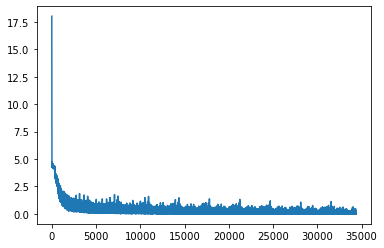

In [41]:
print(losses[-1])
plt.plot(losses)
#plt.plot(valid_accuracy)
#plt.plot(train_accuracy)

In [60]:
y_pred, accuracy = predict(X_train, Y_train, parameters)
print(accuracy)

0.9912454545454545


M


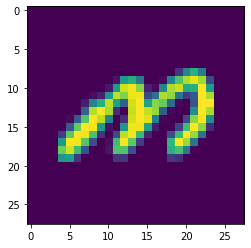

In [57]:
num = 4047
l = list(string.ascii_uppercase)

Im = X_test[:,num].copy()
Im = Im.reshape(28,28)
print(l[y_pred[:,num].argmax()])
plt.imshow(Im)